## **Disclaimer** 
#### El análisis del conjunto de datos de cáncer de mama es exclusivamente con fines educativos y de investigación. Los resultados y conclusiones presentados aquí no deben considerarse como asesoramiento médico, diagnóstico o recomendaciones para tratamiento. Este análisis no ha sido revisado ni aprobado por profesionales médicos.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropFeatures
from feature_engine.encoding import RareLabelEncoder
from feature_engine.discretisation import ArbitraryDiscretiser
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer, MinMaxScaler
from feature_engine.transformation import BoxCoxTransformer
from sklearn.linear_model import BayesianRidge
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [3]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from feature_engine.transformation import YeoJohnsonTransformer

In [4]:
import scipy.stats as stats
from feature_engine.outliers import Winsorizer

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
from phik import phik_matrix

In [7]:
from sklearn import datasets

raw_data = datasets.load_breast_cancer()
raw_data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

In [8]:
print(raw_data["DESCR"])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

:Number of Instances: 569

:Number of Attributes: 30 numeric, predictive attributes and the class

:Attribute Information:
    - radius (mean of distances from center to points on the perimeter)
    - texture (standard deviation of gray-scale values)
    - perimeter
    - area
    - smoothness (local variation in radius lengths)
    - compactness (perimeter^2 / area - 1.0)
    - concavity (severity of concave portions of the contour)
    - concave points (number of concave portions of the contour)
    - symmetry
    - fractal dimension ("coastline approximation" - 1)

    The mean, standard error, and "worst" or largest (mean of the three
    worst/largest values) of these features were computed for each image,
    resulting in 30 features.  For instance, field 0 is Mean Radius, field
    10 is Radius SE, field 20 is Worst Radius.

    - 

1. Radio: Es la distancia desde el centro del tumor hasta su borde.
2. Textura: Mide la variabilidad en la intensidad de los píxeles en la imagen del tumor.
3. Perímetro: Es la longitud total del borde del tumor.
4. Área: Es el número de píxeles dentro del borde del tumor.
5. Suavidad: Mide la variabilidad en la intensidad de los píxeles en la superficie del tumor.
6. Compactación: Mide cuán compacta es la forma del tumor.
7. Concavidad: Mide la profundidad de los huecos en la forma del tumor.
8. Puntos Cóncavos: Son los puntos en el borde del tumor donde la forma se pliega hacia adentro.
9. Simetría: Mide cuán simétrico es el tumor en relación con su centro.
10. Dimensión Fractal: Mide la complejidad del borde del tumor.

Mean se refiere al promedio de los valores medidos para una característica específica

El standard error (se) o error estándar es una medida de la variabilidad de los valores de una característica. Indica cuán dispersos están los valores de esa característica alrededor del promedio.

Worst hace referencia al valor más alto o el peor caso para una característica entre todas las muestras del tumor.

- Radio, Perímetro, Área: Miden el tamaño físico del tumor. Los tumores malignos tienden a ser más grandes y con más variabilidad en estas medidas.
- Textura, Suavidad, Simetría: Miden la regularidad de la superficie del tumor. Los tumores malignos tienden a ser más irregulares y con bordes más rugosos.
- Compactación, Concavidad, Puntos Cóncavos: Miden la irregularidad en la forma del tumor. Los tumores malignos suelen tener formas más irregulares y bordes dentados o con huecos.
- Dimensión Fractal: Mide la complejidad del borde. Los tumores malignos suelen tener bordes más complejos.

In [12]:
columns=raw_data["feature_names"]
columns

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [13]:
df = pd.DataFrame(raw_data["data"],
                           columns=raw_data["feature_names"]
                          )

df["target"] = raw_data.target

In [14]:
df

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0          17.99         10.38          122.80     1001.0          0.11840   
1          20.57         17.77          132.90     1326.0          0.08474   
2          19.69         21.25          130.00     1203.0          0.10960   
3          11.42         20.38           77.58      386.1          0.14250   
4          20.29         14.34          135.10     1297.0          0.10030   
..           ...           ...             ...        ...              ...   
564        21.56         22.39          142.00     1479.0          0.11100   
565        20.13         28.25          131.20     1261.0          0.09780   
566        16.60         28.08          108.30      858.1          0.08455   
567        20.60         29.33          140.10     1265.0          0.11780   
568         7.76         24.54           47.92      181.0          0.05263   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
0             0.27760         0.30010              0.14710         0.2419   
1             0.07864         0.08690              0.07017         0.1812   
2             0.15990         0.19740              0.12790         0.2069   
3             0.28390         0.24140              0.10520         0.2597   
4             0.13280         0.19800              0.10430         0.1809   
..                ...             ...                  ...            ...   
564           0.11590         0.24390              0.13890         0.1726   
565           0.10340         0.14400              0.09791         0.1752   
566           0.10230         0.09251              0.05302         0.1590   
567           0.27700         0.35140              0.15200         0.2397   
568           0.04362         0.00000              0.00000         0.1587   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                   0.07871  ...          17.33           184.60      2019.0   
1                   0.05667  ...          23.41           158.80      1956.0   
2                   0.05999  ...          25.53           152.50      1709.0   
3                   0.09744  ...          26.50            98.87       567.7   
4                   0.05883  ...          16.67           152.20      1575.0   
..                      ...  ...            ...              ...         ...   
564                 0.05623  ...          26.40           166.10      2027.0   
565                 0.05533  ...          38.25           155.00      1731.0   
566                 0.05648  ...          34.12           126.70      1124.0   
567                 0.07016  ...          39.42           184.60      1821.0   
568                 0.05884  ...          30.37            59.16       268.6   

     worst smoothness  worst compactness  worst concavity  \
0             0.16220            0.66560           0.7119   
1             0.12380            0.18660           0.2416   
2             0.14440            0.42450           0.4504   
3             0.20980            0.86630           0.6869   
4             0.13740            0.20500           0.4000   
..                ...                ...              ...   
564           0.14100            0.21130           0.4107   
565           0.11660            0.19220           0.3215   
566           0.11390            0.30940           0.3403   
567           0.16500            0.86810           0.9387   
568           0.08996            0.06444           0.0000   

     worst concave points  worst symmetry  worst fractal dimension  target  
0                  0.2654          0.4601                  0.11890       0  
1                  0.1860          0.2750                  0.08902       0  
2                  0.2430          0.3613                  0.08758       0  
3                  0.2575          0.6638                  0.17300       0  
4                  0.1625          0.2364                  0.076

Class Distribution: 212 - Malignant, 357 - Benign

In [16]:
df.target.value_counts(True)

target
1    0.627417
0    0.372583
Name: proportion, dtype: float64

In [17]:
#### Intercambiar los valores de la variable objetivo de forma tal que 1 sea maligno y 0 benigno
df['target'] = df['target'].replace({0: 1, 1: 0})

De esta manera queda que:
El target es una variable binaria donde:
0: Benigno
1: Maligno

In [19]:
df.target.value_counts(True)

target
0    0.627417
1    0.372583
Name: proportion, dtype: float64

In [20]:
df.shape

(569, 31)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [22]:
df.duplicated().sum()

0

In [23]:
df.isnull().sum()

mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
target                     0
dtype: int64

In [24]:
df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst texture  \
count     569.000000              569.000000  ...     569.000000   
mean        0.181162                0.062798  ...      25.677223   
std         0.027414                0.007060  ...       6.146258   
min         0.106000                0.049960  ...      12.020000   
25%         0.161900                0.057700  ...      21.080000   
50%         0.179200                0.061540  ...      25.410000   
75%         0.195700                0.066120  ...      29.720000   
max         0.304000                0.097440  ...      49.540000   

       worst perimeter   worst area  worst smoothness  worst compactness  \
count       569.000000   569.000000        569.000000         569.000000   
mean        107.261213   880.583128          0.132369           0.254265   
std          33.602542   569.356993          0.022832           0.157336   
min          50.410000   185.200000          0.071170           0.027290   
25%          84.110000   515.300000          0.116600           0.147200   
50%          97.660000   686.500000          0.131300           0.211900   
75%         125.400000  1084.000000          0.146000           0.339100   
max         251.200000  4254.000000          0.222600           1.058000   

       worst concavity  worst concave points  worst symmetry  \
count       569.000000            569.000000      569.000000   
mean          0.272188              0.114606        0.290076   
std           0.208624              0.065732        0.061867   
min           0.000000              0.000000        0.156500   
25%           0.114500              0.064930        0.250400   
50%           0.226700              0.099930        0.282200   
75%           0.382900              0.161400        0.317900   
max           1.252000              0.291000        0.663800   

       worst fractal dimension      target  
count               569.000000  569.000000  
mean                  0.083946    0.372583  
std                   0.018061    0.483918  
min                   0.055040    0.000000  
25%                   0.071460    0.000000  
50%                   0.080040    0.000000  
75%                   0.092080    1.000000  
max                   0.207500    1.000000  

[8 rows x 31 columns]

In [25]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [5, 3]

In [26]:
df_copy = df.copy()
df_copy['target'] = df_copy['target'].astype('category')

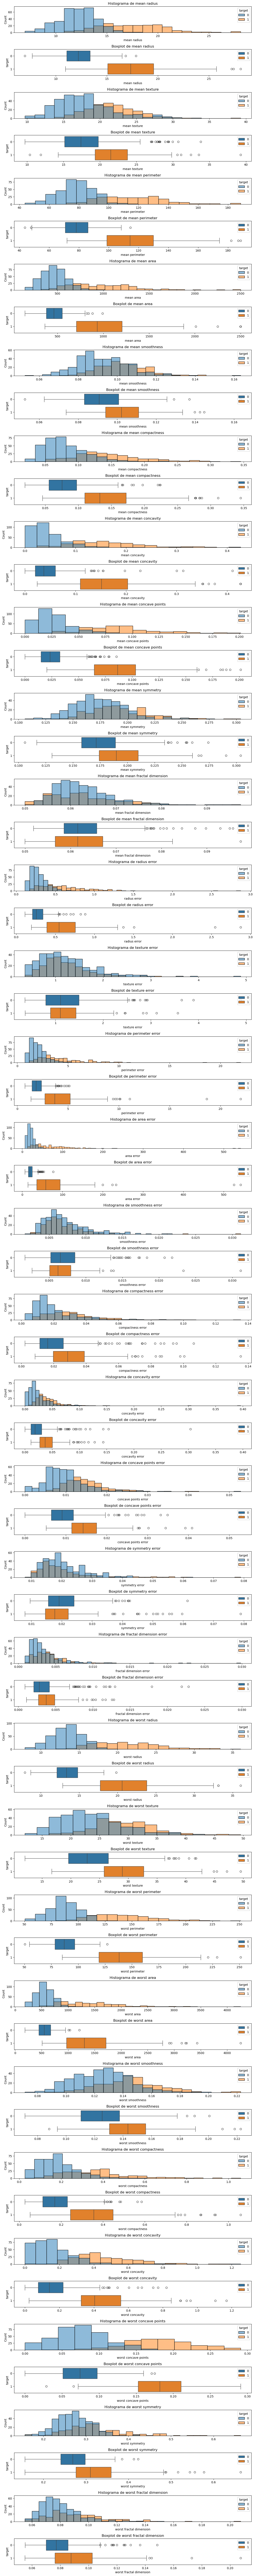

In [27]:
# Tamaño ajustado para la figura
plt.figure(figsize=(12, 4*len(df_copy.columns)))  # Ajustamos el tamaño de la figura

i = 0  # Contador para las posiciones de subgráfico
for var in df_copy.columns:
    if var != 'target':  # No queremos graficar esta columna como variable
        
        # Histograma
        i += 1
        plt.subplot(2*len(df_copy.columns), 1, i)  # Posición en una única columna
        sns.histplot(data=df_copy, x=var, stat="count", hue='target')
        plt.title(f'Histograma de {var}')
        
        # Boxplot
        i += 1
        plt.subplot(2*len(df_copy.columns), 1, i)  # Posición en una única columna
        sns.boxplot(y='target', x=var, data=df_copy, hue='target')
        plt.title(f'Boxplot de {var}')
        plt.legend(loc='upper right')

# Ajuste de diseño para que no se superpongan
plt.tight_layout()
plt.show()

#### Podemos notar que la mayoría de las caracteristicas presentan distribuciones diferentes en relación a la variable objetivo

In [29]:
# Calcular la matriz de correlación usando phik
corr_matrix = phik_matrix(df);

interval columns not set, guessing: ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension', 'target']


In [30]:
# Crear una máscara para el triángulo superior
mask = np.zeros_like(corr_matrix, dtype=bool)
mask[np.triu_indices_from(mask)] = True

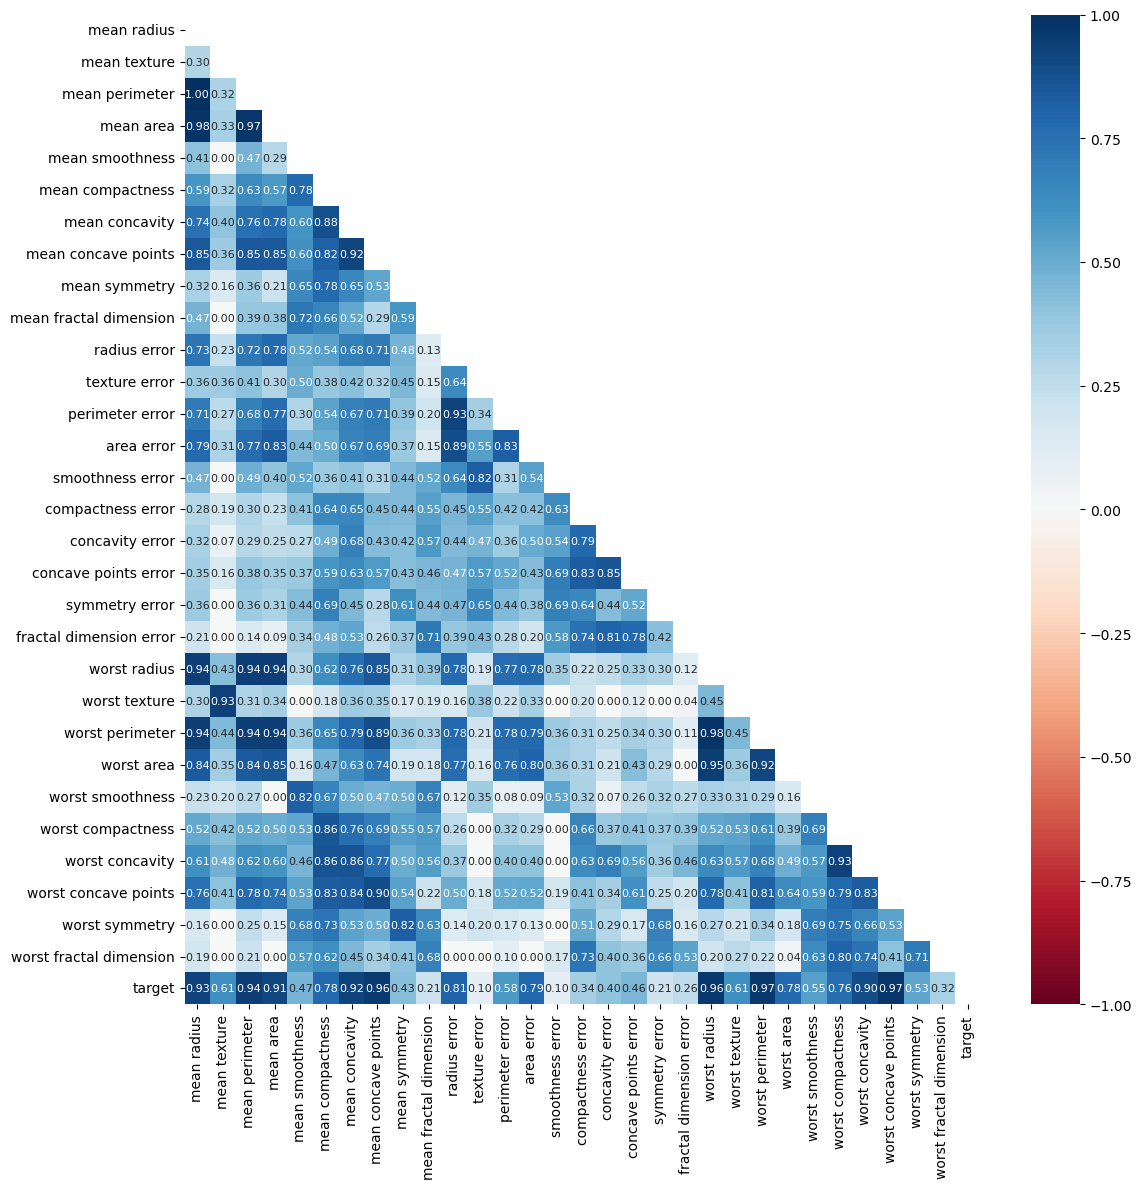

In [31]:
# Correlación de la matriz (suponiendo que ya tienes 'corr_matrix' definida)
plt.figure(figsize=(12, 12))

# Heatmap con tamaño de letras ajustado
sns.heatmap(corr_matrix, annot=True, cmap='RdBu', fmt='.2f', mask=mask, vmin= -1, vmax= 1, center = 0,
            annot_kws={'size': 8},  # Reduce el tamaño de las anotaciones
            # cbar_kws={'label': 'Correlación'},  # Etiqueta para la barra de color
            # xticklabels=5,  # Reduce la cantidad de etiquetas en los ejes x
            # yticklabels=5   # Reduce la cantidad de etiquetas en los ejes y
           )  

# Ajustar el diseño
plt.tight_layout()
plt.show()

#### Gran parte de las variables estan altamente correlacionadas con la variable objetivo
#### En el siguiente heatmap volvemos a verificar las correlaciones entre las variables independiente con el coeficiente de spearman

In [33]:
X = df.drop(columns = "target")
y = df.loc[:, ['target']]

<Figure size 500x300 with 0 Axes>

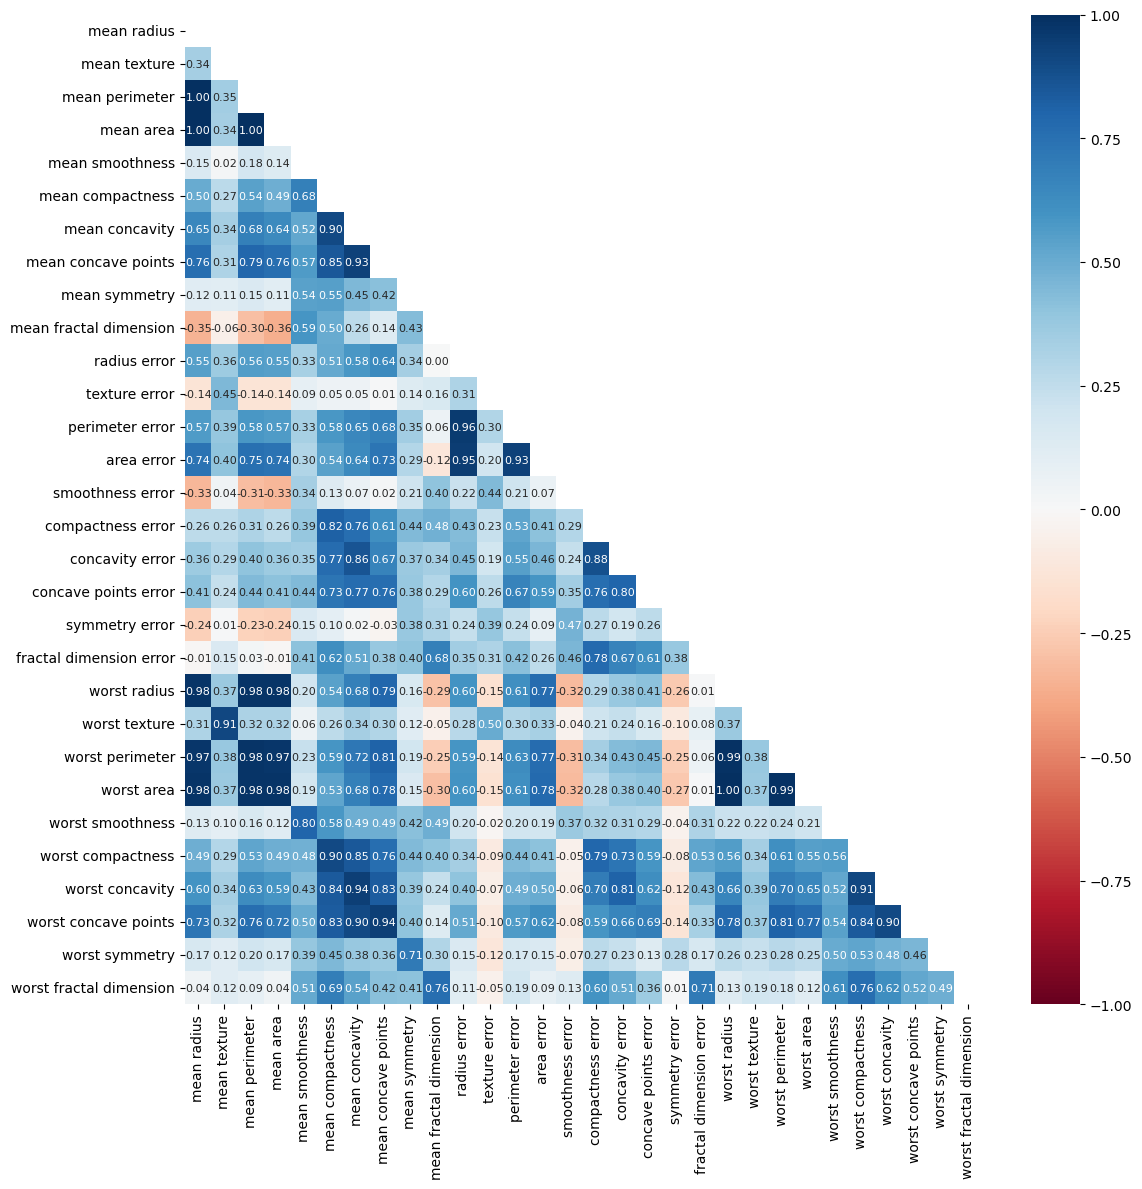

In [34]:
# Ajustar el diseño
plt.tight_layout()
plt.show()

# Calcular la matriz de correlación
corr = X.corr(method='spearman').round(2)

# Crear la máscara para el triángulo superior
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 12))

# Heatmap con tamaño de letras ajustado
sns.heatmap(corr, annot=True, cmap='RdBu', fmt='.2f', mask=mask, vmin=-1, vmax=1, center=0,
            annot_kws={'size': 8},  # Reduce el tamaño de las anotaciones
            # cbar_kws={'label': 'Correlación'},  # Etiqueta para la barra de color
            # xticklabels=5,  # Reduce la cantidad de etiquetas en los ejes x
            # yticklabels=5   # Reduce la cantidad de etiquetas en los ejes y
           )  

# Ajustar el diseño
plt.tight_layout()
plt.show()

In [35]:
import math

In [36]:
# Convertir el objeto Index a una lista
num_cols_list = enumerate(X.columns)

# Filtrar la lista para excluir 'Flag_abandono'
num_cols = [col for col in num_cols_list if col != 'target']

In [37]:
# Calcular la cantidad total de gráficos de dispersión
total_plots = math.comb(len(num_cols), 2)
total_plots

435

In [38]:
#### Dada la cantidad de datos de tipo flotante, la cantidad de convinaciones de graficos de dispersion posible son 435

### Separo el conjunto de datos en los conjuntos de entrenamiento y prueba

In [40]:
y;

In [41]:
X_train, X_test, y_train, y_test = train_test_split( X,y,test_size = 0.2,random_state = 42, stratify=y)

In [42]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 455 entries, 10 to 335
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              455 non-null    float64
 1   mean texture             455 non-null    float64
 2   mean perimeter           455 non-null    float64
 3   mean area                455 non-null    float64
 4   mean smoothness          455 non-null    float64
 5   mean compactness         455 non-null    float64
 6   mean concavity           455 non-null    float64
 7   mean concave points      455 non-null    float64
 8   mean symmetry            455 non-null    float64
 9   mean fractal dimension   455 non-null    float64
 10  radius error             455 non-null    float64
 11  texture error            455 non-null    float64
 12  perimeter error          455 non-null    float64
 13  area error               455 non-null    float64
 14  smoothness error         455 n

In [43]:
X_train.shape

(455, 30)

In [44]:
y_train.shape

(455, 1)

#### Normalización de datos

In [46]:
numerical_columns = X_train.select_dtypes(include=['float64']).columns  # seleccionamos solo columnas numéricas que son todas

# Inicializamos el YeoJohnsonTransformer de feature_engine
yjt = YeoJohnsonTransformer()

# Ajustamos y transformamos las columnas numéricas
X_train_transformed = X_train.copy()

# Ajustamos y transformamos todas las columnas numéricas a la vez
X_train_transformed[numerical_columns] = yjt.fit_transform(X_train[numerical_columns])

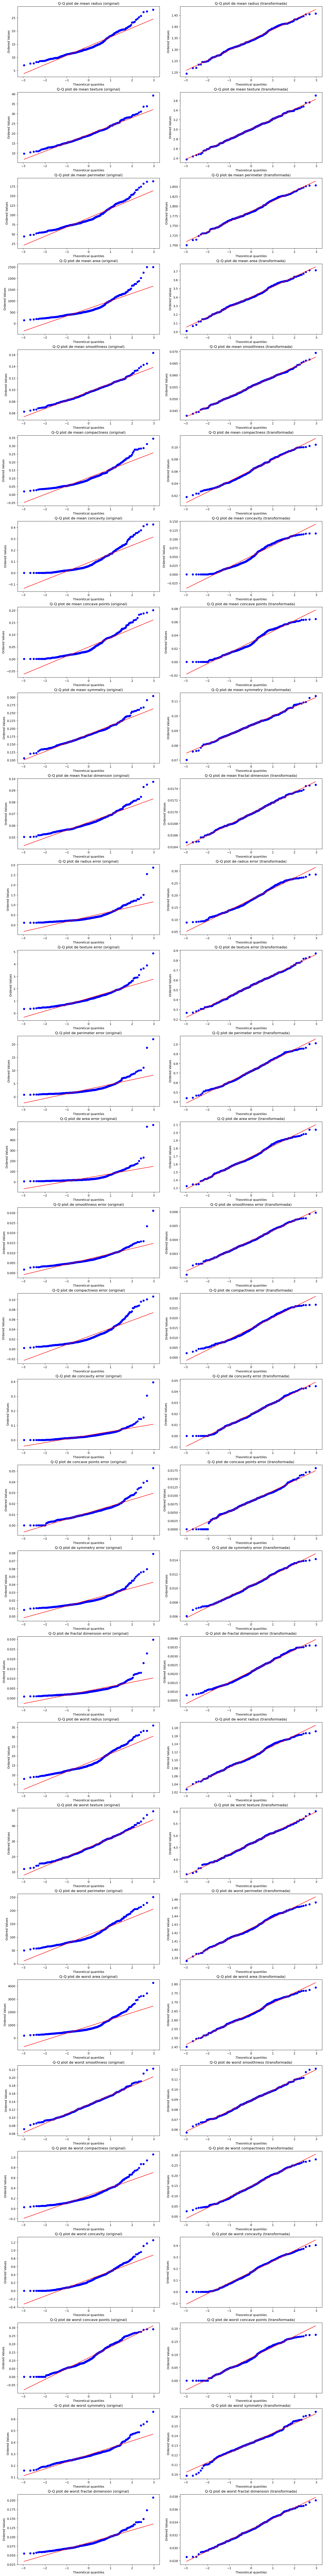

In [47]:
# Función para hacer los Q-Q plots
def make_qqplot(df, original_columns, transformed_df):
    # Crear figura con tamaño dinámico según el número de columnas
    plt.figure(figsize=(15, len(original_columns)*4), constrained_layout=True)
    
    # Graficar Q-Q plot para cada variable
    for i, col in enumerate(original_columns):
        # Subgráfico para la variable original (a la izquierda)
        ax1 = plt.subplot(len(original_columns), 2, 2*i + 1)
        stats.probplot(df[col], dist="norm", plot=ax1)
        ax1.set_title(f'Q-Q plot de {col} (original)')
        
        # Subgráfico para la variable transformada (a la derecha)
        ax2 = plt.subplot(len(original_columns), 2, 2*i + 2)
        # Aplicamos la transformación y mostramos en el gráfico
        stats.probplot(transformed_df[col], dist="norm", plot=ax2)
        ax2.set_title(f'Q-Q plot de {col} (transformada)')

    # Mostrar los gráficos
    plt.show()

# Llamar a la función para generar los Q-Q plots
make_qqplot(X_train, numerical_columns, X_train_transformed)

In [48]:
X_test_transformed = X_test.copy()
X_test_transformed[numerical_columns] = yjt.transform(X_test[numerical_columns])

### Verificación de outliers luego de las transformaciones

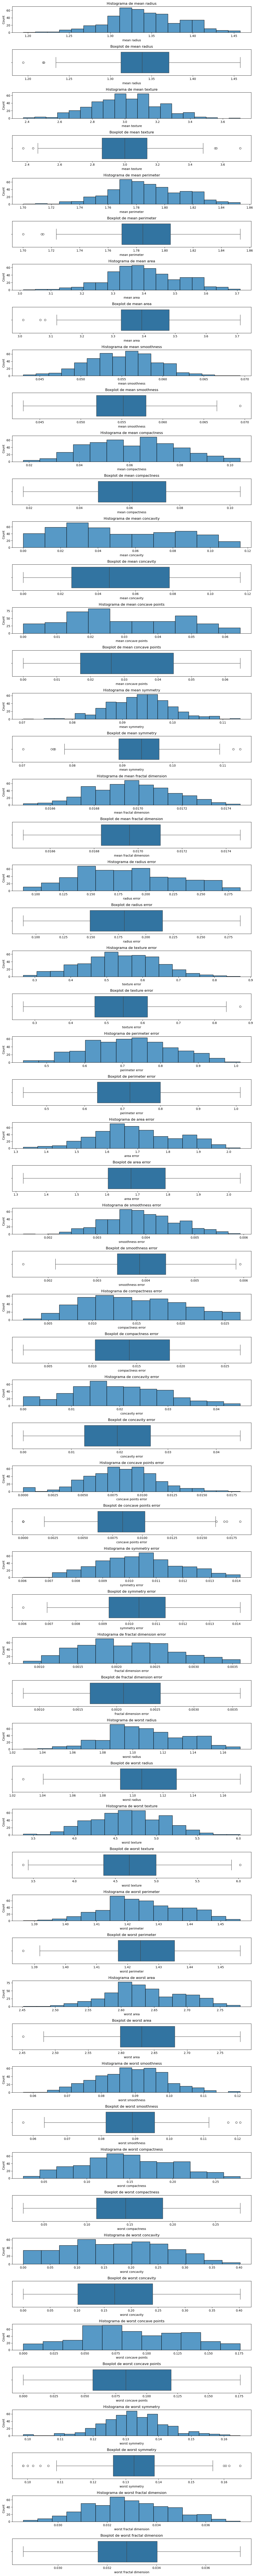

In [50]:
# Tamaño ajustado para la figura
plt.figure(figsize=(12, 4*len(X_train_transformed.columns)))  # Ajustamos el tamaño de la figura

i = 0  # Contador para las posiciones de subgráfico
for var in X_train_transformed.columns:
        
    # Histograma
    i += 1
    plt.subplot(2*len(X_train_transformed.columns), 1, i)  # Posición en una única columna
    sns.histplot(data=X_train_transformed, x=var, stat="count")
    plt.title(f'Histograma de {var}')
    
    # Boxplot
    i += 1
    plt.subplot(2*len(X_train_transformed.columns), 1, i)  # Posición en una única columna
    sns.boxplot(x=var, data=X_train_transformed)
    plt.title(f'Boxplot de {var}')

# Ajuste de diseño para que no se superpongan
plt.tight_layout()
plt.show()

In [51]:
# Definir la función para contar los valores fuera de los límites
def count_outliers(df):
    outliers_count = {}  # Diccionario para almacenar los resultados

    # Iterar sobre cada columna
    for col in df.columns:
        # Calcular los percentiles 25 (Q1) y 75 (Q3)
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        
        # Calcular el IQR (rango intercuartílico)
        IQR = Q3 - Q1
        
        # Calcular los límites inferior y superior
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Contar los valores fuera de los límites
        lower_outliers = (df[col] < lower_limit).sum()
        upper_outliers = (df[col] > upper_limit).sum()
        
        # Guardar el resultado en el diccionario
        outliers_count[col] = {
            "lower_outliers": lower_outliers,
            "upper_outliers": upper_outliers,
            "total_outliers": lower_outliers + upper_outliers
        }
    
    return outliers_count

# Llamar a la función y mostrar los resultados
outliers = count_outliers(X_train_transformed)

In [52]:
# Convertir el diccionario en un DataFrame para una mejor visualización
outliers_df = pd.DataFrame(outliers).T  # Transponer para tener las columnas como índices
outliers_df = outliers_df.sort_values(by=['total_outliers'], ascending=False)
outliers_df

lower_outliers  upper_outliers  total_outliers
concave points error                 11               4              15
worst symmetry                        6               4              10
mean symmetry                         4               2               6
mean texture                          2               3               5
worst smoothness                      1               3               4
mean radius                           3               0               3
mean perimeter                        3               0               3
mean area                             3               0               3
worst texture                         1               1               2
smoothness error                      1               1               2
worst area                            1               0               1
worst perimeter                       1               0               1
symmetry error                        1               0               1
texture error                         0               1               1
worst radius                          1               0               1
mean smoothness                       0               1               1
worst concavity                       0               0               0
worst concave points                  0               0               0
worst compactness                     0               0               0
compactness error                     0               0               0
fractal dimension error               0               0               0
concavity error                       0               0               0
area error                            0               0               0
perimeter error                       0               0               0
radius error                          0               0               0
mean fractal dimension                0               0               0
mean concave points                   0               0               0
mean concavity                        0               0               0
mean compactness                      0               0               0
worst fractal dimension               0               0               0

In [53]:
# Función para contar los outliers por fila
def count_outliers_per_row(df):
    # Crear un DataFrame vacío para almacenar los resultados
    outliers_per_row = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        # Crear una columna en outliers_per_row que indique si el valor está fuera de los límites
        outliers_per_row[col] = (df[col] < lower_limit) | (df[col] > upper_limit)
    
    # Contar el número de outliers por fila
    outliers_per_row_count = outliers_per_row.sum(axis=1)
    
    return outliers_per_row_count

# Función para contar cuántas filas tienen n, n-1, n-2, ..., 0 outliers
def count_rows_with_outliers_up_to_max(df):
    # Contamos los outliers por fila
    outliers_per_row_count = count_outliers_per_row(df)
    
    # Encontrar el número máximo de outliers en cualquier fila
    n = outliers_per_row_count.max()
    
    # Diccionario para almacenar el número de filas con x outliers
    rows_with_outliers = {}
    
    for i in range(n + 1):
        # Contar cuántas filas tienen exactamente i outliers
        rows_with_outliers[i] = (outliers_per_row_count == i).sum()
    
    return rows_with_outliers, n

# Llamar a la función para obtener el resultado
rows_with_outliers, n = count_rows_with_outliers_up_to_max(X_train_transformed)

# Mostrar el resultado
print(f"El número máximo de outliers en una fila es: {n}")
for outlier_count, row_count in rows_with_outliers.items():
    print(f"El número de filas con {outlier_count} outliers es: {row_count}")

El número máximo de outliers en una fila es: 7
El número de filas con 0 outliers es: 420
El número de filas con 1 outliers es: 23
El número de filas con 2 outliers es: 6
El número de filas con 3 outliers es: 3
El número de filas con 4 outliers es: 2
El número de filas con 5 outliers es: 0
El número de filas con 6 outliers es: 0
El número de filas con 7 outliers es: 1


In [54]:
# Función para obtener las filas con n outliers
def get_rows_with_n_outliers(df, n):
    # Contamos los outliers por fila
    outliers_per_row_count = count_outliers_per_row(df)
    
    # Filtrar las filas que tienen exactamente n outliers
    rows_with_n_outliers = df[outliers_per_row_count == n]
    
    return rows_with_n_outliers

In [55]:
# Llamar a la función para obtener las filas con n outliers
n = 7  # El valor máximo de outliers
rows_with_n_outliers = get_rows_with_n_outliers(X_train_transformed, n)

In [56]:
indices_with_n_outliers = rows_with_n_outliers.index

# Filtrar el DataFrame original con los índices obtenidos
df_with_n_outliers = df.loc[indices_with_n_outliers]

# Mostrar las filas con exactamente n outliers
print(f"Filas con exactamente {n} outliers en el DataFrame original:")
df_with_n_outliers

Filas con exactamente 7 outliers en el DataFrame original:


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
101        6.981         13.43           43.79      143.5            0.117   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
101           0.07568             0.0                  0.0          0.193   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
101                 0.07818  ...          19.54            50.41       185.2   

     worst smoothness  worst compactness  worst concavity  \
101            0.1584             0.1202              0.0   

     worst concave points  worst symmetry  worst fractal dimension  target  
101                   0.0          0.2932                  0.09382       0  

[1 rows x 31 columns]

In [57]:
df.describe()

mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%           0.086370          0.064920        0.029560             0.020310   
50%           0.095870          0.092630        0.061540             0.033500   
75%           0.105300          0.130400        0.130700             0.074000   
max           0.163400          0.345400        0.426800             0.201200   

       mean symmetry  mean fractal dimension  ...  worst texture  \
count     569.000000              569.000000  ...     569.000000   
mean        0.181162                0.062798  ...      25.677223   
std         0.027414                0.007060  ...       6.146258   
min         0.106000                0.049960  ...      12.020000   
25%         0.161900                0.057700  ...      21.080000   
50%         0.179200                0.061540  ...      25.410000   
75%         0.195700                0.066120  ...      29.720000   
max         0.304000                0.097440  ...      49.540000   

       worst perimeter   worst area  worst smoothness  worst compactness  \
count       569.000000   569.000000        569.000000         569.000000   
mean        107.261213   880.583128          0.132369           0.254265   
std          33.602542   569.356993          0.022832           0.157336   
min          50.410000   185.200000          0.071170           0.027290   
25%          84.110000   515.300000          0.116600           0.147200   
50%          97.660000   686.500000          0.131300           0.211900   
75%         125.400000  1084.000000          0.146000           0.339100   
max         251.200000  4254.000000          0.222600           1.058000   

       worst concavity  worst concave points  worst symmetry  \
count       569.000000            569.000000      569.000000   
mean          0.272188              0.114606        0.290076   
std           0.208624              0.065732        0.061867   
min           0.000000              0.000000        0.156500   
25%           0.114500              0.064930        0.250400   
50%           0.226700              0.099930        0.282200   
75%           0.382900              0.161400        0.317900   
max           1.252000              0.291000        0.663800   

       worst fractal dimension      target  
count               569.000000  569.000000  
mean                  0.083946    0.372583  
std                   0.018061    0.483918  
min                   0.055040    0.000000  
25%                   0.071460    0.000000  
50%                   0.080040    0.000000  
75%                   0.092080    1.000000  
max                   0.207500    1.000000  

[8 rows x 31 columns]

In [58]:
# Llamar a la función para obtener las filas con n outliers
n = 4  # El valor máximo de outliers
rows_with_n_outliers = get_rows_with_n_outliers(X_train_transformed, n)

indices_with_n_outliers = rows_with_n_outliers.index

# Filtrar el DataFrame original con los índices obtenidos
df_with_n_outliers = df.loc[indices_with_n_outliers]

# Mostrar las filas con exactamente n outliers
print(f"Filas con exactamente {n} outliers en el DataFrame original:")
df_with_n_outliers

Filas con exactamente 4 outliers en el DataFrame original:


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
538        7.729         25.49           47.98      178.8          0.08098   
192        9.720         18.22           60.73      288.1          0.06950   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
538           0.04878             0.0                  0.0         0.1870   
192           0.02344             0.0                  0.0         0.1653   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
538                 0.07285  ...          30.92            57.17       248.0   
192                 0.06447  ...          20.83            62.25       303.8   

     worst smoothness  worst compactness  worst concavity  \
538           0.12560            0.08340              0.0   
192           0.07117            0.02729              0.0   

     worst concave points  worst symmetry  worst fractal dimension  target  
538                   0.0          0.3058                  0.09938       0  
192                   0.0          0.1909                  0.06559       0  

[2 rows x 31 columns]

In [59]:
# Llamar a la función para obtener las filas con n outliers
n = 3  # El valor máximo de outliers
rows_with_n_outliers = get_rows_with_n_outliers(X_train_transformed, n)

indices_with_n_outliers = rows_with_n_outliers.index

# Filtrar el DataFrame original con los índices obtenidos
df_with_n_outliers = df.loc[indices_with_n_outliers]

# Mostrar las filas con exactamente n outliers
print(f"Filas con exactamente {n} outliers en el DataFrame original:")
df_with_n_outliers

Filas con exactamente 3 outliers en el DataFrame original:


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
213       17.420         25.56          114.50      948.0          0.10060   
561       11.200         29.37           70.67      386.0          0.07449   
539        7.691         25.44           48.34      170.4          0.08668   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
213           0.11460         0.16820              0.06597         0.1308   
561           0.03558         0.00000              0.00000         0.1060   
539           0.11990         0.09252              0.01364         0.2037   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
213                 0.05866  ...          28.07           120.40      1021.0   
561                 0.05502  ...          38.30            75.19       439.6   
539                 0.07751  ...          31.89            54.49       223.6   

     worst smoothness  worst compactness  worst concavity  \
213           0.12430            0.17930           0.2803   
561           0.09267            0.05494           0.0000   
539           0.15960            0.30640           0.3393   

     worst concave points  worst symmetry  worst fractal dimension  target  
213                0.1099          0.1603                  0.06818       1  
561                0.0000          0.1566                  0.05905       0  
539                0.0500          0.2790                  0.10660       0  

[3 rows x 31 columns]

In [60]:
# Llamar a la función para obtener las filas con n outliers
n = 2  # El valor máximo de outliers
rows_with_n_outliers = get_rows_with_n_outliers(X_train_transformed, n)

indices_with_n_outliers = rows_with_n_outliers.index

# Filtrar el DataFrame original con los índices obtenidos
df_with_n_outliers = df.loc[indices_with_n_outliers]

# Mostrar las filas con exactamente n outliers
print(f"Filas con exactamente {n} outliers en el DataFrame original:")
df_with_n_outliers

Filas con exactamente 2 outliers en el DataFrame original:


mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
3          11.42         20.38           77.58      386.1          0.14250   
166        10.80          9.71           68.77      357.6          0.09594   
259        15.53         33.56          103.70      744.9          0.10630   
491        17.85         13.23          114.60      992.1          0.07838   
78         20.18         23.97          143.70     1245.0          0.12860   
38         14.99         25.20           95.54      698.8          0.09387   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
3             0.28390         0.24140              0.10520         0.2597   
166           0.05736         0.02531              0.01698         0.1381   
259           0.16390         0.17510              0.08399         0.2091   
491           0.06217         0.04445              0.04178         0.1220   
78            0.34540         0.37540              0.16040         0.2906   
38            0.05131         0.02398              0.02899         0.1565   

     mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
3                   0.09744  ...          26.50            98.87       567.7   
166                 0.06400  ...          12.02            73.66       414.0   
259                 0.06650  ...          49.54           126.30      1035.0   
491                 0.05243  ...          18.42           127.10      1210.0   
78                  0.08142  ...          31.72           170.30      1623.0   
38                  0.05504  ...          25.20            95.54       698.8   

     worst smoothness  worst compactness  worst concavity  \
3             0.20980            0.86630          0.68690   
166           0.14360            0.12570          0.10470   
259           0.18830            0.55640          0.57030   
491           0.09862            0.09976          0.10480   
78            0.16390            0.61640          0.76810   
38            0.09387            0.05131          0.02398   

     worst concave points  worst symmetry  worst fractal dimension  target  
3                 0.25750          0.6638                  0.17300       1  
166               0.04603          0.2090                  0.07699       0  
259               0.20140          0.3512                  0.12040       1  
491               0.08341          0.1783                  0.05871       0  
78                0.25080          0.5440                  0.09964       1  
38                0.02899          0.1565                  0.05504       1  

[6 rows x 31 columns]

In [61]:
# Crear el transformador con IQR y un factor de 1.5
winsorizer = Winsorizer(capping_method='iqr', 
                        tail='both',       # 'both' recorta valores de ambos lados (inferior y superior)
                        fold=1.5           # factor para los límites del IQR
                       )

# Aplicar el recorte a las columnas seleccionadas
X_train_cleaned = winsorizer.fit_transform(X_train_transformed)
X_test_cleaned = winsorizer.transform(X_test_transformed)  # Recuerda usar 'transform' para el conjunto de prueba

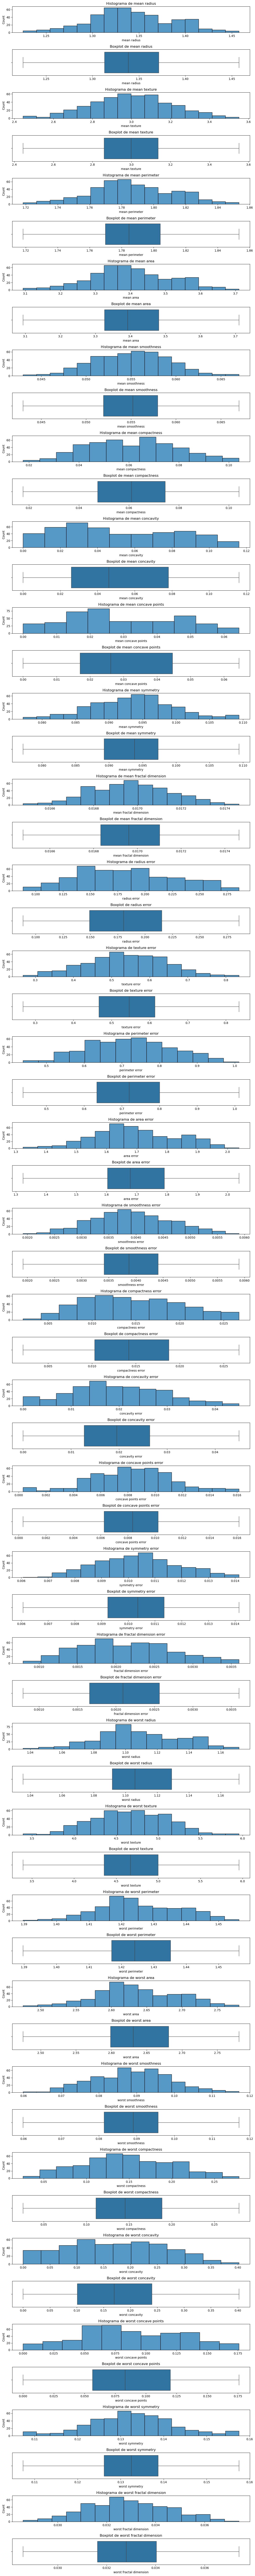

In [62]:
# Tamaño ajustado para la figura
plt.figure(figsize=(12, 4*len(X_train_cleaned.columns)))  # Ajustamos el tamaño de la figura

i = 0  # Contador para las posiciones de subgráfico
for var in X_train_cleaned.columns:
        
    # Histograma
    i += 1
    plt.subplot(2*len(X_train_cleaned.columns), 1, i)  # Posición en una única columna
    sns.histplot(data=X_train_cleaned, x=var, stat="count")
    plt.title(f'Histograma de {var}')
    
    # Boxplot
    i += 1
    plt.subplot(2*len(X_train_cleaned.columns), 1, i)  # Posición en una única columna
    sns.boxplot(x=var, data=X_train_cleaned)
    plt.title(f'Boxplot de {var}')

# Ajuste de diseño para que no se superpongan
plt.tight_layout()
plt.show()

In [63]:
# Para el pipeline
# ('outlier_adjustment', OutlierAdjuster(variables=['Fare', 'Age'])),

### Escalo los valores

In [65]:
scaler = MinMaxScaler().set_output(transform="pandas")

In [66]:
# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train_cleaned)

MinMaxScaler()

In [67]:
# transform train and test sets
X_train_scale = scaler.transform(X_train_cleaned)
X_test_scale = scaler.transform(X_test_cleaned)

In [68]:
columns = X_train_scale.columns.tolist()

In [69]:
# Separar las columnas en tres grupos
mean_columns = [col for col in columns if col.startswith('mean')]
error_columns = [col for col in columns if col.endswith('error')]
worst_columns = [col for col in columns if col.startswith('worst')]

In [70]:
df_train = X_train_scale.copy()
df_train_mean = X_train_scale[mean_columns]
df_train_error = X_train_scale[error_columns]
df_train_worst = X_train_scale[worst_columns]

In [71]:
df_train.shape

(455, 30)

In [72]:
df_test = X_test_scale.copy()
df_test_mean = X_test_scale[mean_columns]
df_test_error = X_test_scale[error_columns]
df_test_worst = X_test_scale[worst_columns]

In [73]:
y_train = y_train.values.flatten()
y_test = y_test.values.flatten()

### Busco el mejor modelo 

In [75]:
def objective_logit(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'penalty': trial.suggest_categorical('logit_penalty', ['l1', 'l2']),
        'C': trial.suggest_float('logit_c', 1e-5, 1e2, log=True),
        'solver': trial.suggest_categorical('logit_solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('logit_max_iter', 100, 1000),
    }
    
    # Crear el modelo utilizando **param
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [76]:
def objective_svc(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'C': trial.suggest_float('svc_c', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly']),
        'gamma': trial.suggest_categorical('svc_gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('svc_degree', 2, 4),
        'random_state': 42
    }
    
    # Crear el modelo base SVC
    model = SVC(**param)
    
    # Calibrar para obtener predict_proba
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid')
    calibrated_model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [77]:
from sklearn.calibration import CalibratedClassifierCV

def objective_svc(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'C': trial.suggest_float('svc_c', 1e-5, 1e2, log=True),
        'kernel': trial.suggest_categorical('svc_kernel', ['linear', 'poly']),
        'gamma': trial.suggest_categorical('svc_gamma', ['scale', 'auto']),
        'degree': trial.suggest_int('svc_degree', 2, 4),
        'random_state': 42
    }
    
    # Crear el modelo base SVC
    model = SVC(**param)
    # Calibrar el modelo para obtener predict_proba
    calibrated_model = CalibratedClassifierCV(model, method='sigmoid', cv=5)
    
    # Usar el modelo calibrado para la validación cruzada
    score = cross_val_score(calibrated_model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [78]:
def objective_gbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("gbm_n_estimators", 50, 200),
        'learning_rate': trial.suggest_float("gbm_learning_rate", 0.01, 0.2),
        'max_depth': trial.suggest_int("gbm_max_depth", 1, 25),
        'min_samples_split': trial.suggest_int("gbm_min_samples_split", 2, 100),
        'min_samples_leaf': trial.suggest_int("gbm_min_samples_leaf", 1, 200),
        'max_features': trial.suggest_categorical("gbm_max_features", ['sqrt', 'log2', None]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = GradientBoostingClassifier(**param)    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [79]:
def objective_knn(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_neighbors': trial.suggest_int('knn_n_neighbors', 3, 49, step=2),
        'weights': trial.suggest_categorical('knn_weights', ['uniform', 'distance']),
        'p': trial.suggest_int('knn_p', 1, 2),
    }

    # Crear el modelo utilizando **param
    model = KNeighborsClassifier(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [80]:
def objective_naive(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'var_smoothing': trial.suggest_float('naive_var_smoothing', 1e-3, 1e0, log=True)
    }

    # Crear el modelo utilizando **param
    model = GaussianNB(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [81]:
def objective_rf(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'n_estimators': trial.suggest_int("rf_n_estimators", 50, 300),
        'max_depth': trial.suggest_int("rf_max_depth", 1, 30),
        'min_samples_split': trial.suggest_int("rf_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("rf_min_samples_leaf", 1, 400),
        'max_features': trial.suggest_categorical("rf_max_features", [None, 'sqrt', 'log2']),
        'bootstrap': trial.suggest_categorical("rf_bootstrap", [True, False]),
        'random_state': 42
    }
    
    # Crear el modelo utilizando **param
    model = RandomForestClassifier(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [82]:
def objective_dt(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'max_depth': trial.suggest_int("dt_max_depth", 1, 20),
        'min_samples_split': trial.suggest_int("dt_min_samples_split", 2, 400),
        'min_samples_leaf': trial.suggest_int("dt_min_samples_leaf", 1, 400),
        'criterion': trial.suggest_categorical("dt_criterion", ["gini", "entropy"]),
        'random_state': 42
    }

    # Crear el modelo utilizando **param
    model = DecisionTreeClassifier(**param)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [83]:
def objective_lgbm(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-5, 1e-2, log=True), 
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 1.0),
        'random_state': 42,
#        'class_weight': 'balanced'  # Address class imbalance
    }

    # Crear el modelo utilizando **param
    model = lgb.LGBMClassifier(**param, verbose=0)
    
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

In [84]:
# Interesa optimizar tanto el recall como la presición
chosen_metric = 'f1'

In [85]:
# Diccionario con los modelos y sus funciones objective correspondientes
model_dict = {
    'lgbm': objective_lgbm,
    'knn': objective_knn,
    'naive': objective_naive,
    'dt': objective_dt,
    'logit': objective_logit,
    'rf': objective_rf,
#    'svc': objective_svc,  #requiere mucho costo computacional
    'gbm': objective_gbm
}

In [86]:
import optuna
from optuna.pruners import HyperbandPruner

In [87]:
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

In [88]:
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, KFold, StratifiedKFold, cross_validate

In [89]:
# Intentar leer el archivo CSV, si no existe, ejecutar la optimización
try:
    # Intentar leer el archivo CSV
    trials_df1 = pd.read_csv("../Breast Cancer/parameters_trials.csv")
    print("Archivo leído correctamente.\n")

except FileNotFoundError:
    # Si el archivo no existe, ejecutar la optimización
    print("Archivo no encontrado. Ejecutando optimización...")

    best_params_df = pd.DataFrame(columns=["model", "params", "score"])  # Agregar columna para la métrica

    # Loop sobre los modelos
    for model_name, objective_func in model_dict.items():
        # Crear el estudio para cada modelo
        study = optuna.create_study(direction='maximize', pruner=HyperbandPruner())

        # Optimizar el modelo con Optuna utilizando su función objective correspondiente
        study.optimize(lambda trial: objective_func(trial, df_train, y_train, metric = chosen_metric), n_trials = 100)

        # Obtener los mejores parámetros y la mejor puntuación
        best_params = study.best_params
        best_score = study.best_value  # Obtiene la mejor puntuación (por ejemplo, accuracy o roc_auc)

        # Imprimir mensaje indicando que la búsqueda terminó para el modelo actual
        print(f'Búsqueda en {model_name} finalizada')
        
        # Guardar en el DataFrame usando pd.concat()
        best_params_df = pd.concat([best_params_df, pd.DataFrame([{"model": model_name, 
                                                                   "params": best_params, 
                                                                   "score": best_score}])], ignore_index=True)

    # Guardar los resultados en un archivo CSV
    best_params_df.to_csv("../Breast Cancer/parameters_trials.csv", index=False)
    print("Resultados guardados en parameters_trials.csv")

# Leer el archivo CSV después de guardar
trials_df1 = pd.read_csv("../Breast Cancer/parameters_trials.csv")
print("Archivo leído correctamente después de la optimización.\n")

Archivo leído correctamente.

Archivo leído correctamente después de la optimización.



In [90]:
trials_df1

model                                             params     score
0   lgbm  {'num_leaves': 52, 'max_depth': 6, 'learning_r...  0.964529
1    knn  {'knn_n_neighbors': 5, 'knn_weights': 'distanc...  0.954574
2  naive      {'naive_var_smoothing': 0.056073087090432266}  0.919395
3     dt  {'dt_max_depth': 6, 'dt_min_samples_split': 23...  0.912885
4  logit  {'logit_penalty': 'l2', 'logit_c': 0.665135612...  0.969594
5     rf  {'rf_n_estimators': 293, 'rf_max_depth': 22, '...  0.935081
6    gbm  {'gbm_n_estimators': 124, 'gbm_learning_rate':...  0.970322

In [91]:
def remove_prefix_and_modify_params(params, model_name, prefix):
    """Elimina el prefijo de los parámetros y cambia 'c' a 'C' para logit y svc."""
    
    # Eliminar el prefijo de los parámetros
    new_params = {}
    for key, value in params.items():

        # Eliminar el prefijo y mantener el valor del parámetro
        if key.startswith(prefix):
            new_key = key[len(prefix):]  # Eliminar el prefijo
        else:
            new_key = key  # Si no tiene prefijo, usamos la clave original

        # Cambiar 'c' a 'C' para los modelos logit y svc
        if model_name in ['logit', 'svc'] and new_key == 'c':
            print(f"Se encontró 'c' como clave para {model_name}. Cambiando a 'C'.")
            new_key = 'C'  # Cambiar 'c' a 'C'

        new_params[new_key] = value
    
    return new_params

# Recorremos cada fila del DataFrame y removemos el prefijo de los parámetros
for index, row in trials_df1.iterrows():
    # Cargar los parámetros de la columna 'params' como diccionario
    params = eval(row['params'])  # Convertir string a diccionario

    # Obtener el nombre del modelo
    model_name = row['model']
    
    # Si el modelo es 'lgbm', no hay prefijo; en otros casos, usamos el nombre del modelo seguido de un guion bajo
    if model_name == "lgbm":
        prefix = ""
    else:
        prefix = f"{model_name}_"

    # Remover el prefijo y cambiar 'c' a 'C' si es necesario
    new_params = remove_prefix_and_modify_params(params, model_name, prefix)

    # Actualizar la columna 'params' con los nuevos parámetros sin prefijo
    trials_df1.at[index, 'params'] = new_params

# Imprimir el DataFrame actualizado después de la depuración
print("\nDataFrame actualizado:")
print(trials_df1)

Se encontró 'c' como clave para logit. Cambiando a 'C'.

DataFrame actualizado:
   model                                             params     score
0   lgbm  {'num_leaves': 52, 'max_depth': 6, 'learning_r...  0.964529
1    knn  {'n_neighbors': 5, 'weights': 'distance', 'p': 2}  0.954574
2  naive            {'var_smoothing': 0.056073087090432266}  0.919395
3     dt  {'max_depth': 6, 'min_samples_split': 230, 'mi...  0.912885
4  logit  {'penalty': 'l2', 'C': 0.665135612617185, 'sol...  0.969594
5     rf  {'n_estimators': 293, 'max_depth': 22, 'min_sa...  0.935081
6    gbm  {'n_estimators': 124, 'learning_rate': 0.16658...  0.970322


#### Evaluación de los modelos

In [93]:
def resultados(y, y_pred, y_proba=None):
    """
    Esta función evalúa el rendimiento de un modelo de clasificación utilizando
    una matriz de confusión y, si se proporcionan probabilidades, la curva AUC-ROC.
    
    Parámetros:
    - y: array-like, valores verdaderos de las etiquetas de clase (etiquetas reales).
    - y_pred: array-like, valores predichos por el modelo (etiquetas predichas).
    - y_proba: array-like, probabilidades predichas por el modelo (opcional).
    """
    # Matriz de confusión
    conf_matrix = confusion_matrix(y, y_pred, normalize='true')
    
    # Configuración de la figura
    if y_proba is None:
        fig, ax = plt.subplots(figsize=(5, 4))  # Una sola figura si no hay `y_proba`
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5, ax=ax)
        ax.set_title("Matriz de Confusión")
        ax.set_ylabel('Real')
        ax.set_xlabel('Predicho')
    else:
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # Dos subfiguras si hay `y_proba`
        
        # Graficar la matriz de confusión
        sns.heatmap(conf_matrix, annot=True, cmap='Blues', vmin=0, vmax=1, center=0.5, ax=axes[0])
        axes[0].set_title("Matriz de Confusión")
        axes[0].set_ylabel('Real')
        axes[0].set_xlabel('Predicho')
        
        # Calcular y graficar la curva AUC-ROC
        fpr, tpr, _ = roc_curve(y, y_proba)
        auc_score = roc_auc_score(y, y_proba)
        axes[1].plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
        axes[1].plot([0, 1], [0, 1], 'k--')  # Línea diagonal para referencia
        axes[1].set_title("Curva AUC-ROC")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Reporte de clasificación
    print(classification_report(y, y_pred))

In [94]:
def model_evaluation(model, X_train, y_train, metric='accuracy'):
    """
    Esta función evalúa el rendimiento del modelo utilizando K-Fold Cross-Validation
    y devuelve métricas de rendimiento, así como el riesgo de sobreajuste.

    Parámetros:
    - model: el modelo a evaluar.
    - X_train: conjunto de datos de entrenamiento.
    - y_train: etiquetas del conjunto de entrenamiento.

    Retorna:
    - df: DataFrame con las métricas de rendimiento.
    - overfitting_risk: diccionario con información sobre el riesgo de sobreajuste.
    """
    # K-Fold Cross-Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    try:
        # Estimación del error de generalización
        clf = cross_validate(
            model,
            X_train,
            y_train,
            scoring= metric,
            return_train_score=True,
            cv=kf
        )

        # Calcular valores para el conjunto de entrenamiento
        mean_train_score = np.mean(clf['train_score'])
        std_train_score = np.std(clf['train_score'])

        # Calcular el intervalo para el conjunto de entrenamiento
        interval_lower_train = mean_train_score - 3 * std_train_score
        interval_upper_train = mean_train_score + 3 * std_train_score

        # Calcular el puntaje medio y el intervalo para el conjunto de prueba
        mean_test_score = np.mean(clf['test_score']) if 'test_score' in clf else np.nan
        std_test_score = np.std(clf['test_score']) if 'test_score' in clf else np.nan

        # Calcular el intervalo para el conjunto de prueba
        interval_lower_test = mean_test_score - 3 * std_test_score if not np.isnan(mean_test_score) else np.nan
        interval_upper_test = mean_test_score + 3 * std_test_score if not np.isnan(mean_test_score) else np.nan

        # Crear el DataFrame con las métricas
        df = pd.DataFrame({
            'mean': [mean_train_score, mean_test_score],
            'std': [std_train_score, std_test_score],
            'interval_lower': [interval_lower_train, interval_lower_test],
            'interval_upper': [interval_upper_train, interval_upper_test]
        }, index=['train_set', 'test_set'])

        # Prueba t para comparar las puntuaciones de entrenamiento y prueba
        t_stat, p_value = stats.ttest_ind(clf['train_score'], clf['test_score'], equal_var=False)

        # Diccionario con la probabilidad de sobreajuste
        overfitting_risk = {
            't_statistic': t_stat,
            'p_value': p_value,
            'overfitting_likelihood': 'High' if p_value < 0.10 else 'Low'
        }

        return df, overfitting_risk

    except Exception as e:
        print(f"Error al evaluar el modelo: {e}")
        return None, None

In [95]:
model_dict = {
    'gbm': GradientBoostingClassifier,
    'knn': KNeighborsClassifier,
    'naive': GaussianNB,
    'dt': DecisionTreeClassifier,
    'lgbm': lgb.LGBMClassifier,
    'logit': LogisticRegression,
    'rf': RandomForestClassifier,
    'svc': SVC
}

In [96]:
y_train.shape

(455,)

In [97]:
import os

In [98]:
# Nombre del archivo CSV relacionado con "comportamiento_mejores_parametros"
csv_filename = "best_params_results.csv"

# Verifica si el archivo ya existe
if os.path.exists(csv_filename):
    # Si el archivo existe, solo se lee y se omite el proceso de evaluación y guardado
    results_df = pd.read_csv(csv_filename)
    print("El archivo ya existe. Se han cargado los resultados desde el archivo.")
else:
    # Si el archivo no existe, se realiza el cálculo y se guarda el archivo
    results_df = pd.DataFrame(columns=["model", "mean_train_score", "std_train_score", "interval_lower_train", 
                                       "interval_upper_train", "mean_test_score", "std_test_score", 
                                       "interval_lower_test", "interval_upper_test", "overfitting_risk", "p_value"])

    # Para cada modelo en trials_df1, crea y entrena el modelo utilizando los parámetros
    for index, row in trials_df1.iterrows():
        model_name = row['model']
        params = row['params']

        # Si el modelo es 'lgbm', no necesita prefijo como los otros modelos
        if model_name != 'lgbm':
            # Remover el prefijo (modelo_name + "_") de los parámetros
            params = {k.replace(f'{model_name}_', ''): v for k, v in params.items()}

        # Crear el modelo usando los parámetros
        model_class = model_dict[model_name]
        model = model_class(**params)

        # # Dividir el dataset en entrenamiento y validación
        # X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(df_train, y_train, test_size=0.2, random_state=42) # Cuando entra al if esta sobreescribiendo los train

        # Evaluar el modelo usando la función 'model_evaluation'
        df, overfitting_risk = model_evaluation(model, df_train, y_train, metric = chosen_metric)

        # Extraer los resultados de la evaluación
        mean_train_score = df.loc['train_set', 'mean']
        std_train_score = df.loc['train_set', 'std']
        interval_lower_train = df.loc['train_set', 'interval_lower']
        interval_upper_train = df.loc['train_set', 'interval_upper']
        
        mean_test_score = df.loc['test_set', 'mean']
        std_test_score = df.loc['test_set', 'std']
        interval_lower_test = df.loc['test_set', 'interval_lower']
        interval_upper_test = df.loc['test_set', 'interval_upper']

        # Extraer el valor p
        p_value = overfitting_risk.get('p_value', 1.0)

        # Crear un diccionario con los resultados para agregar al DataFrame
        results = {
            "model": model_name,
            "mean_train_score": mean_train_score,
            "std_train_score": std_train_score,
            "interval_lower_train": interval_lower_train,
            "interval_upper_train": interval_upper_train,
            "mean_test_score": mean_test_score,
            "std_test_score": std_test_score,
            "interval_lower_test": interval_lower_test,
            "interval_upper_test": interval_upper_test,
            "overfitting_risk": overfitting_risk['overfitting_likelihood'],
            "p_value": p_value
        }

        # Agregar los resultados al DataFrame de resultados
        results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
    
    # Guardar los resultados en el archivo CSV
    results_df.to_csv(csv_filename, index=False)
    print("El archivo ha sido creado y los resultados han sido guardados.")

El archivo ya existe. Se han cargado los resultados desde el archivo.


In [99]:
y_train.shape

(455,)

In [100]:
results_df

model  mean_train_score  std_train_score  interval_lower_train  \
0   lgbm          0.998556         0.001769              0.993250   
1    knn          1.000000         0.000000              1.000000   
2  naive          0.921962         0.008251              0.897208   
3     dt          0.934871         0.003867              0.923269   
4  logit          0.969185         0.002857              0.960615   
5     rf          0.943338         0.005784              0.925987   
6    gbm          0.991826         0.002827              0.983345   

   interval_upper_train  mean_test_score  std_test_score  interval_lower_test  \
0              1.003862         0.950608        0.014060             0.908428   
1              1.000000         0.960891        0.027966             0.876994   
2              0.946716         0.922641        0.039627             0.803760   
3              0.946474         0.907584        0.016314             0.858642   
4              0.977755         0.949673        0.033651             0.848722   
5              0.960689         0.922252        0.027283             0.840403   
6              1.000308         0.958043        0.018040             0.903924   

   interval_upper_test overfitting_risk   p_value  
0             0.992788             High  0.002222  
1             1.044788             High  0.048964  
2             1.041522              Low  0.974719  
3             0.956526             High  0.026751  
4             1.050625              Low  0.311357  
5             1.004101              Low  0.199272  
6             1.012162             High  0.019136

In [101]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

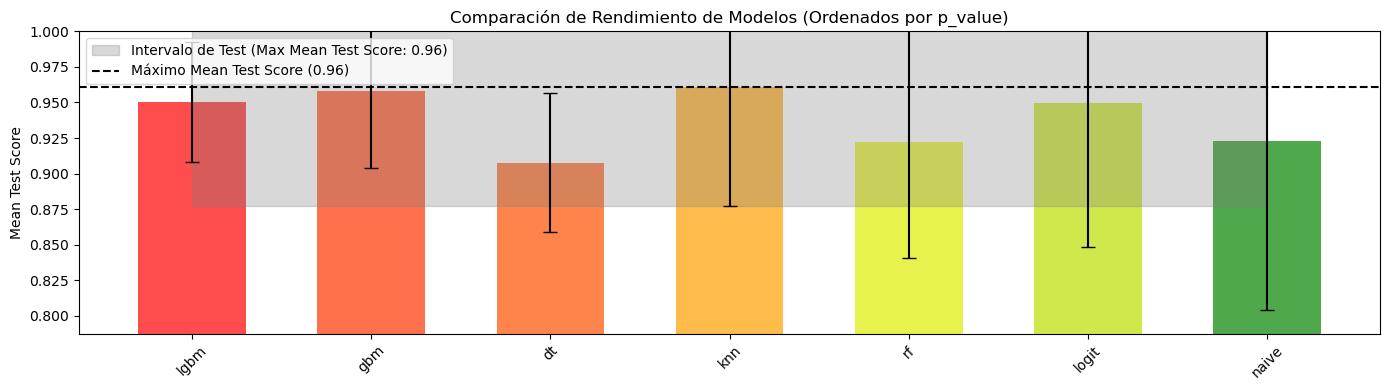

In [102]:
# Ordenar el DataFrame por el valor p creciente
results_df_sorted = results_df.sort_values(by='p_value')

# Crear el gráfico de barras
plt.figure(figsize=(14, 4))  # Ajustar el tamaño de la figura
bar_width = 0.6  # Hacer las barras el doble de anchas

# Obtener todos los modelos únicos después de ordenar
all_models = results_df_sorted['model'].unique()  # Obtener los modelos únicos

# Inicializar posición base
x_pos = np.arange(len(all_models))

# Crear un colormap personalizado para los valores p (ajustado a tus indicaciones)
colors = LinearSegmentedColormap.from_list(
    "p_value_gradient", [(0, 'red'), (0.075, 'yellow'), (1, 'green')])

# Normalizar los valores p de acuerdo con el rango entre 0 y 1
norm = Normalize(vmin=0, vmax=1)

# Graficar las métricas de test (mean_test_score y std_test_score)
max_mean_test_score = -np.inf  # Para encontrar el mayor mean_test_score
interval_lower_test_max = None  # Para almacenar el valor del intervalo inferior
interval_upper_test_max = None  # Para almacenar el valor del intervalo superior
min_mean_test_score = np.inf  # Para encontrar el menor mean_test_score

for i, model in enumerate(all_models):
    # Filtrar los datos para cada modelo
    filtered_df = results_df_sorted[results_df_sorted['model'] == model]
    
    # Obtener las métricas del modelo
    mean_test_score = filtered_df['mean_test_score'].values[0]
    test_std = filtered_df['std_test_score'].values[0] * 3  # Multiplicar la desviación estándar por 3
    p_value = filtered_df['p_value'].values[0]
    
    # Obtener los límites del intervalo de test
    interval_lower_test = filtered_df['interval_lower_test'].values[0]
    interval_upper_test = filtered_df['interval_upper_test'].values[0]
    
    # Actualizar el máximo y el mínimo mean_test_score, así como los límites del intervalo
    if mean_test_score > max_mean_test_score:
        max_mean_test_score = mean_test_score
        interval_lower_test_max = interval_lower_test
        interval_upper_test_max = interval_upper_test
    if mean_test_score < min_mean_test_score:
        min_mean_test_score = mean_test_score

    # Asignar el color basado en el valor p usando el colormap
    color = colors(norm(p_value))  # Aplicar normalización y obtener el color

    # Posicionar las barras
    plt.bar(x_pos[i], mean_test_score, yerr=test_std, capsize=5, 
            color=color, width=bar_width, alpha=0.7)

# Añadir una banda translucida entre interval_lower_test_max y interval_upper_test_max
plt.fill_between(
    [0, len(all_models) - 1],  # Todo el ancho del gráfico
    interval_lower_test_max, interval_upper_test_max,
    color='gray', alpha=0.3, label=f'Intervalo de Test (Max Mean Test Score: {max_mean_test_score:.2f})'
)

# Añadir línea horizontal en el valor máximo de mean_test_score
plt.axhline(y=max_mean_test_score, color='black', linestyle='--', label=f'Máximo Mean Test Score ({max_mean_test_score:.2f})')

# Añadir etiquetas y título
plt.title('Comparación de Rendimiento de Modelos (Ordenados por p_value)')
plt.xticks(x_pos, all_models, rotation=45)
plt.ylabel('Mean Test Score')

# Ajustar el límite del eje y
plt.ylim(min_mean_test_score - 0.12, 1.0)  # Se ajusta el límite inferior para incluir el valor mínimo

# Añadir leyenda
plt.legend(loc='upper left')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [103]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

In [104]:
knn_best_params = trials_df1[trials_df1['model'] == 'knn']['params'].iloc[0]
print(knn_best_params)

{'n_neighbors': 5, 'weights': 'distance', 'p': 2}


In [105]:
knn_classifier = KNeighborsClassifier(**knn_best_params)
knn_classifier.fit(df_train, y_train)
y_train_pred = knn_classifier.predict(X = df_train)
y_test_pred = knn_classifier.predict(X = df_test)
y_train_proba = knn_classifier.predict_proba(df_train)[:, 1]
y_test_proba = knn_classifier.predict_proba(df_test)[:, 1]

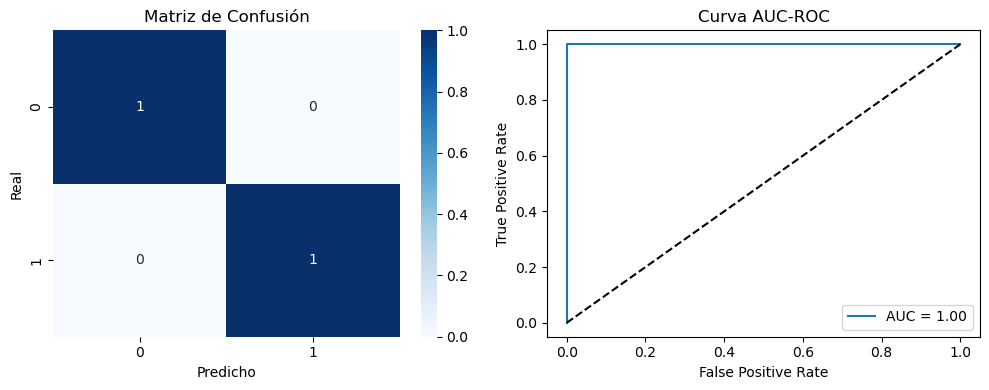

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455



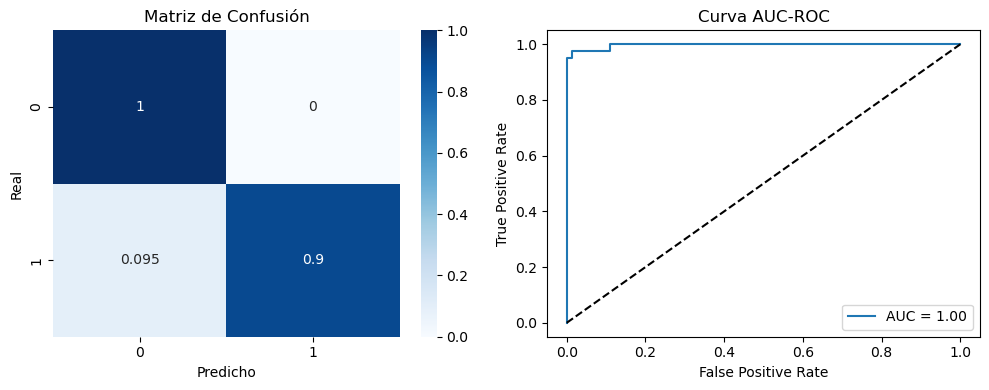

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [106]:
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

In [107]:
logit_best_params = trials_df1[trials_df1['model'] == 'logit']['params'].iloc[0]
print(logit_best_params)

{'penalty': 'l2', 'C': 0.665135612617185, 'solver': 'saga', 'max_iter': 495}


In [108]:
logit_classifier = LogisticRegression(**logit_best_params)
logit_classifier.fit(df_train, y_train)
y_train_pred = logit_classifier.predict(X = df_train)
y_test_pred = logit_classifier.predict(X = df_test)
y_train_proba = logit_classifier.predict_proba(df_train)[:, 1]
y_test_proba = logit_classifier.predict_proba(df_test)[:, 1]

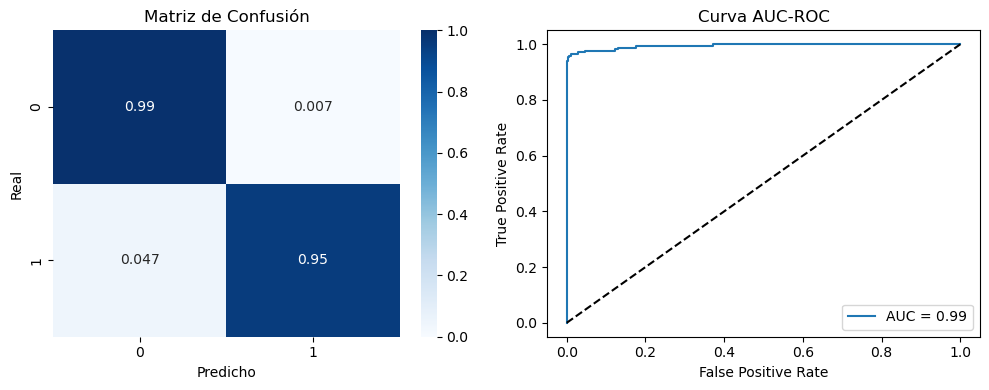

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       285
           1       0.99      0.95      0.97       170

    accuracy                           0.98       455
   macro avg       0.98      0.97      0.98       455
weighted avg       0.98      0.98      0.98       455



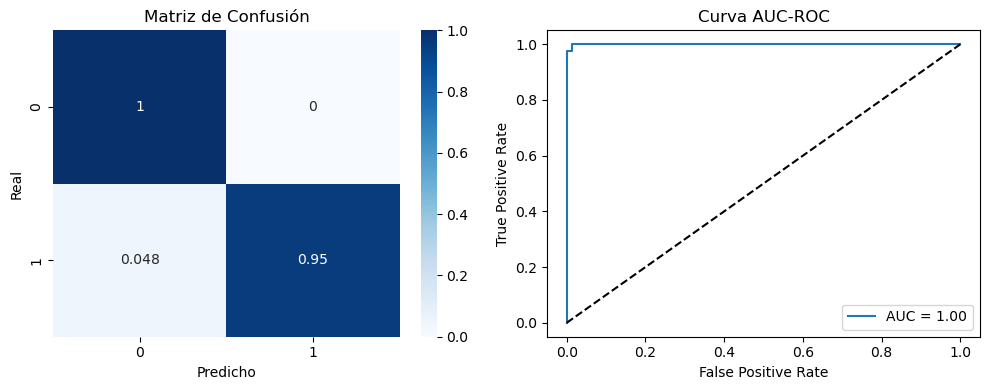

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [109]:
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

In [110]:
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, roc_curve, auc, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

C:\Users\germa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\germa\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


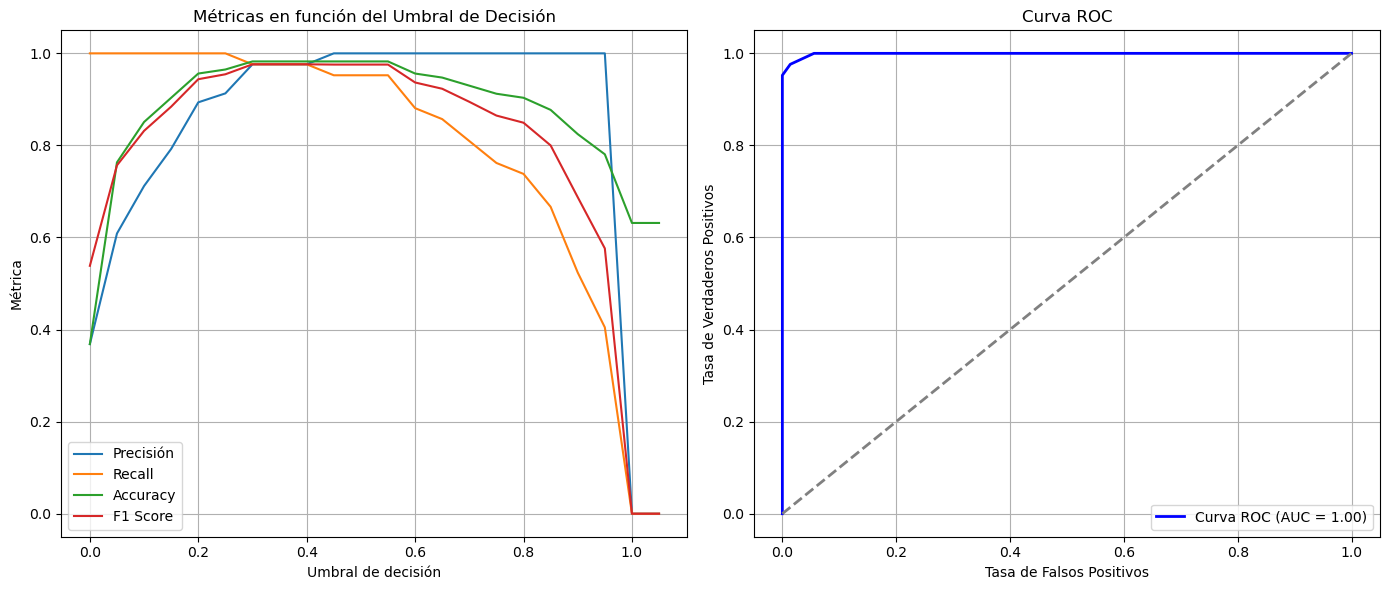

In [111]:
# Calcular todas las métricas y trazar las curvas ROC y de Precision-Recall
thresholds = np.arange(0.0, 1.1, 0.05)
precisions, recalls, accuracies, f1_scores, fprs, tprs = [], [], [], [], [], []

for threshold in thresholds:
    y_pred_threshold = (y_test_proba >= threshold).astype(int)
    precision = precision_score(y_test, y_pred_threshold)
    recall = recall_score(y_test, y_pred_threshold)
    accuracy = accuracy_score(y_test, y_pred_threshold)
    f1 = f1_score(y_test, y_pred_threshold)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_threshold).ravel()
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    precisions.append(precision)
    recalls.append(recall)
    accuracies.append(accuracy)
    f1_scores.append(f1)
    fprs.append(fpr)
    tprs.append(recall)

# Calcular AUC para ROC
roc_auc = auc(fprs, tprs)

plt.figure(figsize=(14, 6))

# Gráficos de las diferentes métricas
plt.subplot(1, 2, 1)
plt.plot(thresholds, precisions, label='Precisión')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, accuracies, label='Accuracy')
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.xlabel('Umbral de decisión')
plt.ylabel('Métrica')
plt.title('Métricas en función del Umbral de Decisión')
plt.legend()
plt.grid(True)

# Gráfico ROC
plt.subplot(1, 2, 2)
plt.plot(fprs, tprs, color='blue', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.grid(True)

plt.tight_layout()
plt.show()

#### Es preferible predecir el 100% de los casos que las celulas son malignas, por lo que cambiamos la

In [113]:
class LogisticRegressionWithThreshold:
    def __init__(self, threshold=0.5, **kwargs):
        self.model = LogisticRegression(**kwargs)
        self.threshold = threshold

    def fit(self, X, y):
        # Entrena el modelo
        self.model.fit(X, y)

    def predict(self, X):
        # Obtiene las probabilidades de la clase positiva
        y_pred_probs = self.model.predict_proba(X)[:, 1]
        # Aplica el umbral personalizado para predecir 0 o 1
        return (y_pred_probs >= self.threshold).astype(int)

    def predict_proba(self, X):
        # Retorna las probabilidades predichas como en el modelo original
        return self.model.predict_proba(X)

In [114]:
# Ejemplo de uso
custom_logit_classifier = LogisticRegressionWithThreshold(threshold=0.20, **logit_best_params)
custom_logit_classifier.fit(df_train, y_train)

y_train_pred = custom_logit_classifier.predict(X = df_train)
y_test_pred = custom_logit_classifier.predict(X = df_test)
y_train_proba = custom_logit_classifier.predict_proba(df_train)[:, 1]
y_test_proba = custom_logit_classifier.predict_proba(df_test)[:, 1]

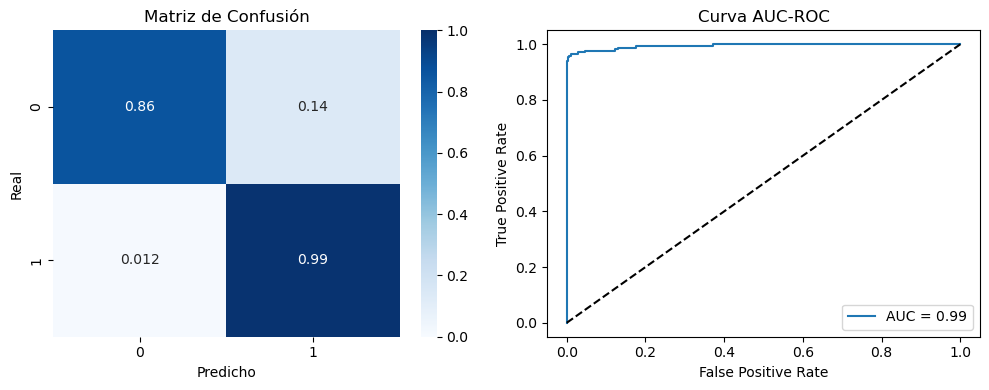

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       285
           1       0.81      0.99      0.89       170

    accuracy                           0.91       455
   macro avg       0.90      0.93      0.91       455
weighted avg       0.92      0.91      0.91       455



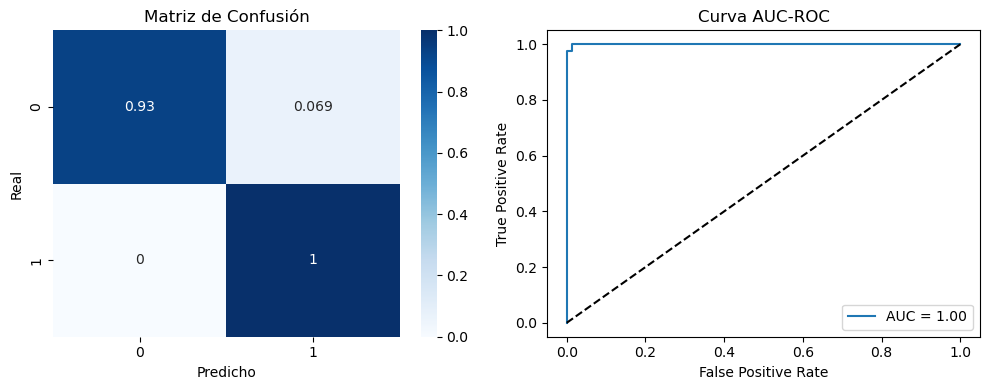

              precision    recall  f1-score   support

           0       1.00      0.93      0.96        72
           1       0.89      1.00      0.94        42

    accuracy                           0.96       114
   macro avg       0.95      0.97      0.95       114
weighted avg       0.96      0.96      0.96       114



In [115]:
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

In [116]:
# Ejemplo de uso
custom_logit_classifier = LogisticRegressionWithThreshold(threshold=0.05, **logit_best_params)
custom_logit_classifier.fit(df_train, y_train)

y_train_pred = custom_logit_classifier.predict(X = df_train)
y_test_pred = custom_logit_classifier.predict(X = df_test)
y_train_proba = custom_logit_classifier.predict_proba(df_train)[:, 1]
y_test_proba = custom_logit_classifier.predict_proba(df_test)[:, 1]

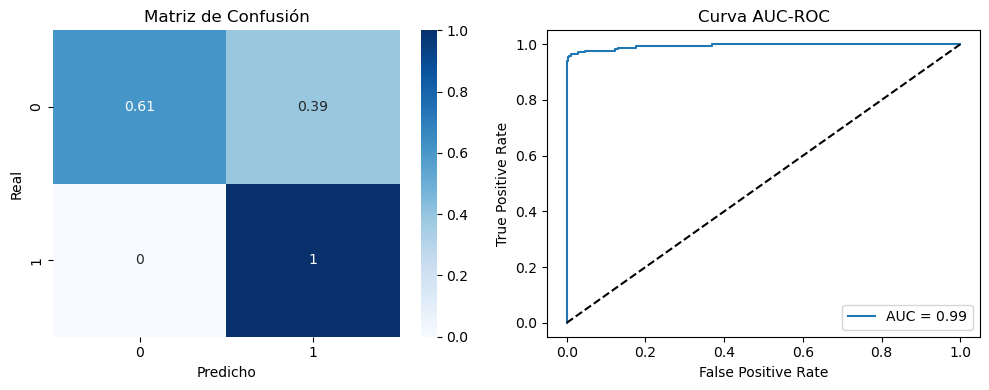

              precision    recall  f1-score   support

           0       1.00      0.61      0.76       285
           1       0.60      1.00      0.75       170

    accuracy                           0.76       455
   macro avg       0.80      0.81      0.76       455
weighted avg       0.85      0.76      0.76       455



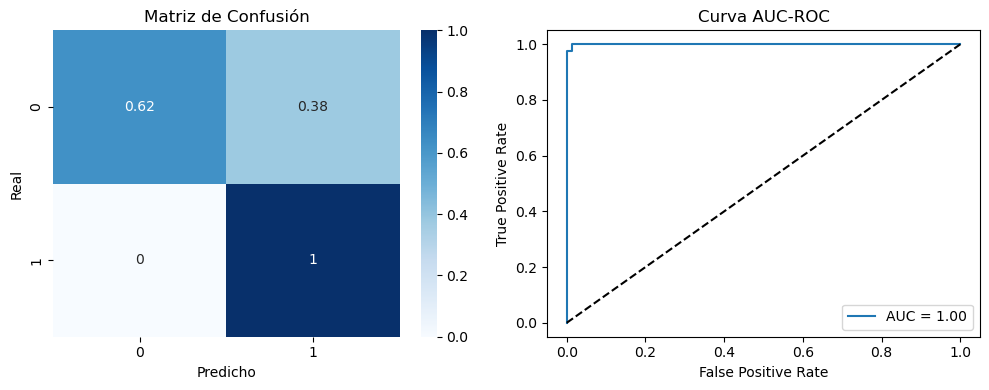

              precision    recall  f1-score   support

           0       1.00      0.62      0.77        72
           1       0.61      1.00      0.76        42

    accuracy                           0.76       114
   macro avg       0.80      0.81      0.76       114
weighted avg       0.86      0.76      0.76       114



In [117]:
resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### Con un umbral de 20% modelo aumentamos las falsas alarmas en un 18% detectaremos correctamente el 99.4% de los casos de cancer
#### Si decimos que los resultados de un paciente tiene 5% o más porciento de probabilidad de tener cancer, para esta muestra detectamos el 100% de los pacientes con cancer pero aumentamos las falsas alarmar a 40%. 
#### Para tener resultados más certeros es conveninete tener 

### Seleccion de caracteristicas

#### ¿Son más importantes los valores medios, las desviaciones estandar o las mediciones maximas?

In [121]:
# df_train_mean = X_train_scale[mean_columns]
# df_train_error = X_train_scale[error_columns]
# df_train_worst = X_train_scale[worst_columns]

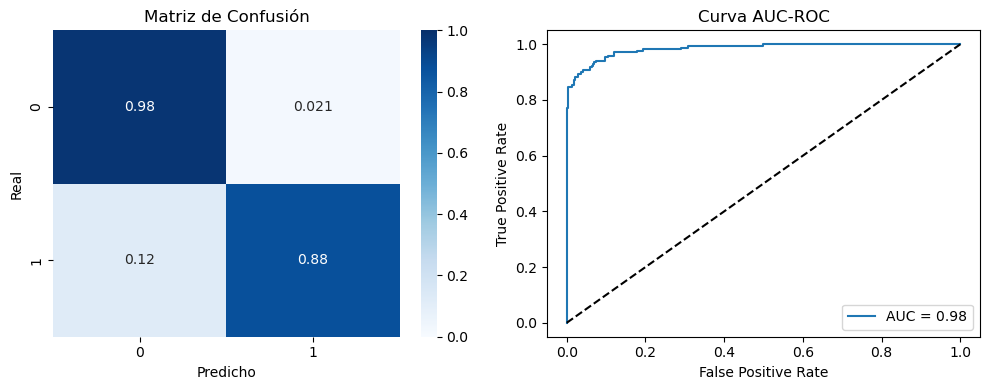

              precision    recall  f1-score   support

           0       0.93      0.98      0.95       285
           1       0.96      0.88      0.92       170

    accuracy                           0.94       455
   macro avg       0.95      0.93      0.94       455
weighted avg       0.94      0.94      0.94       455



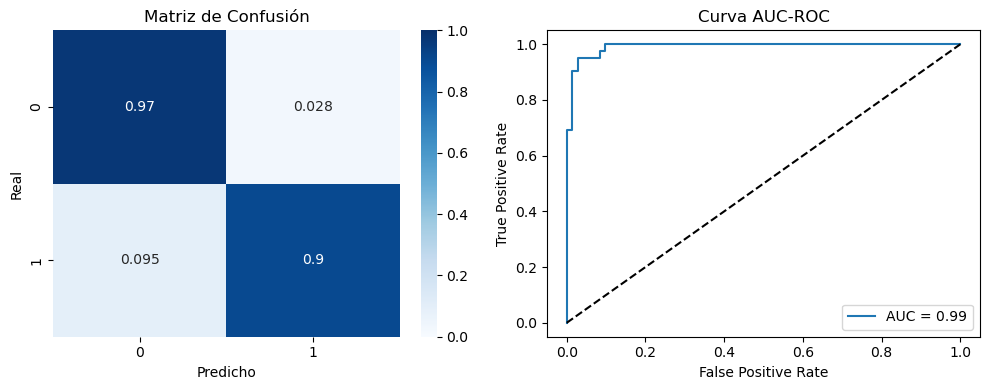

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [122]:
logit_classifier = LogisticRegression(**logit_best_params)
logit_classifier.fit(df_train_mean, y_train)
y_train_pred = logit_classifier.predict(X = df_train_mean)
y_test_pred = logit_classifier.predict(X = df_test_mean)
y_train_proba = logit_classifier.predict_proba(df_train_mean)[:, 1]
y_test_proba = logit_classifier.predict_proba(df_test_mean)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

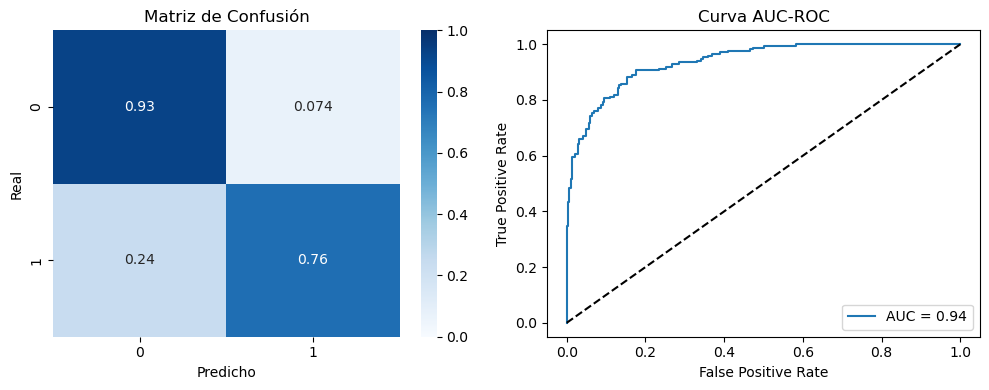

              precision    recall  f1-score   support

           0       0.87      0.93      0.89       285
           1       0.86      0.76      0.81       170

    accuracy                           0.86       455
   macro avg       0.86      0.84      0.85       455
weighted avg       0.86      0.86      0.86       455



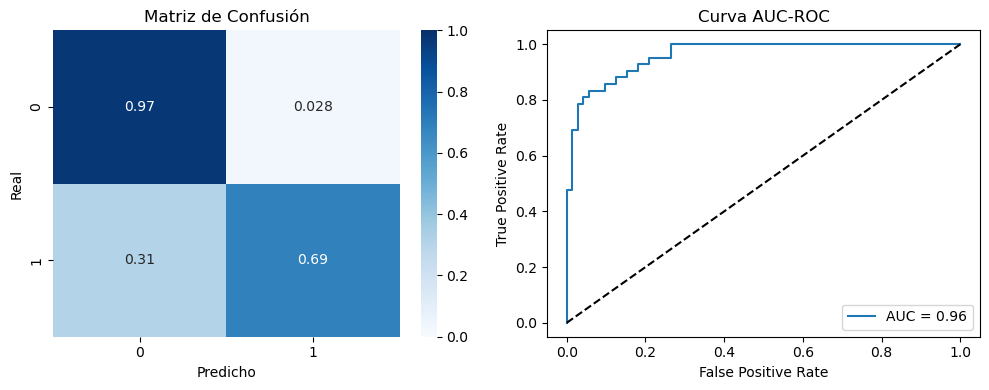

              precision    recall  f1-score   support

           0       0.84      0.97      0.90        72
           1       0.94      0.69      0.79        42

    accuracy                           0.87       114
   macro avg       0.89      0.83      0.85       114
weighted avg       0.88      0.87      0.86       114



In [123]:
logit_classifier = LogisticRegression(**logit_best_params)
logit_classifier.fit(df_train_error, y_train)
y_train_pred = logit_classifier.predict(X = df_train_error)
y_test_pred = logit_classifier.predict(X = df_test_error)
y_train_proba = logit_classifier.predict_proba(df_train_error)[:, 1]
y_test_proba = logit_classifier.predict_proba(df_test_error)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

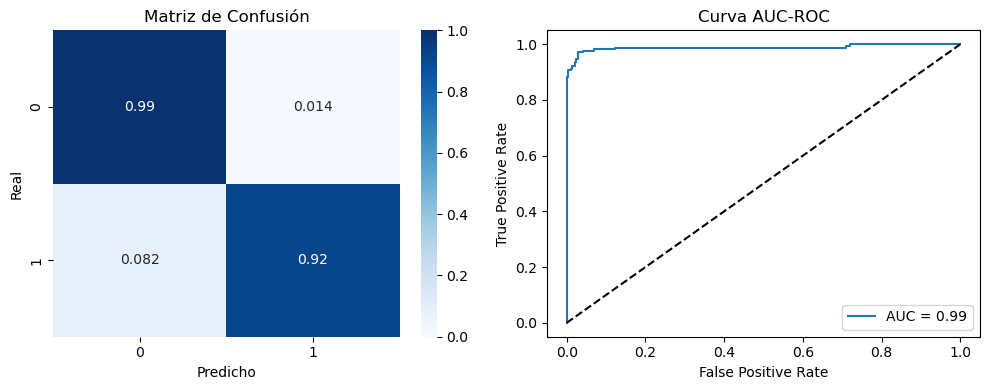

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       285
           1       0.97      0.92      0.95       170

    accuracy                           0.96       455
   macro avg       0.96      0.95      0.96       455
weighted avg       0.96      0.96      0.96       455



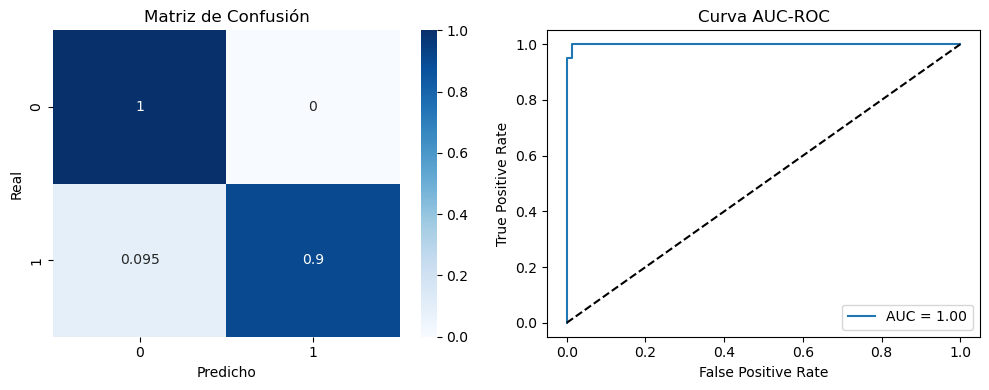

              precision    recall  f1-score   support

           0       0.95      1.00      0.97        72
           1       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [124]:
logit_classifier = LogisticRegression(**logit_best_params)
logit_classifier.fit(df_train_worst, y_train)
y_train_pred = logit_classifier.predict(X = df_train_worst)
y_test_pred = logit_classifier.predict(X = df_test_worst)
y_train_proba = logit_classifier.predict_proba(df_train_worst)[:, 1]
y_test_proba = logit_classifier.predict_proba(df_test_worst)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### A primer instancia las peores mediciones son las que mejor poder predictivo tienen para detectar si las celulas son cancerigenas o no.
#### De todos modos vamos a analizar las caracteristicas por separado.

#### Para seleccionar las caracteristicas más importantes y poder compararlas entre ellas buscaremos los mejores parametros para un modelo de regresion logistica con regulación lasso

In [127]:
def objective_logit(trial, X_train, y_train, metric='accuracy'):
    # Definir los parámetros del modelo en un diccionario
    param = {
        'penalty': trial.suggest_categorical('logit_penalty', ['l1']),
        'C': trial.suggest_float('logit_c', 1e-5, 1e2, log=True),
        'solver': trial.suggest_categorical('logit_solver', ['liblinear', 'saga']),
        'max_iter': trial.suggest_int('logit_max_iter', 100, 1000)
    }
    
    # Crear el modelo utilizando **param
    model = LogisticRegression(**param)
    model.fit(X_train, y_train)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring=metric).mean()
    
    return score

#### Para poder los coeficientes de las caracteristicas escalamos.

In [129]:
feature_scaler = MinMaxScaler().set_output(transform="pandas")
feature_scaler.fit(X_train)
# transform train and test sets
X_train_scale_1 = scaler.transform(X_train)
X_test_scale_1 = scaler.transform(X_test)

In [130]:
# study = optuna.create_study(direction='maximize')
# study.optimize(lambda trial: objective_logit(trial, X_train_scale_1, y_train, metric = chosen_metric), n_trials = 100) 
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)
# logit_best_params = study.best_trial.params
# logit_best_params

In [291]:
log_params = {
    'penalty': 'l1',
    'C': 4.767461011746043,
    'solver': 'liblinear',
    'max_iter': 500, # Se tuvo que aumentar la cantidad de iteraciones, esto puede denotar complejidad en la relacion de las variables
    'random_state': 42
}

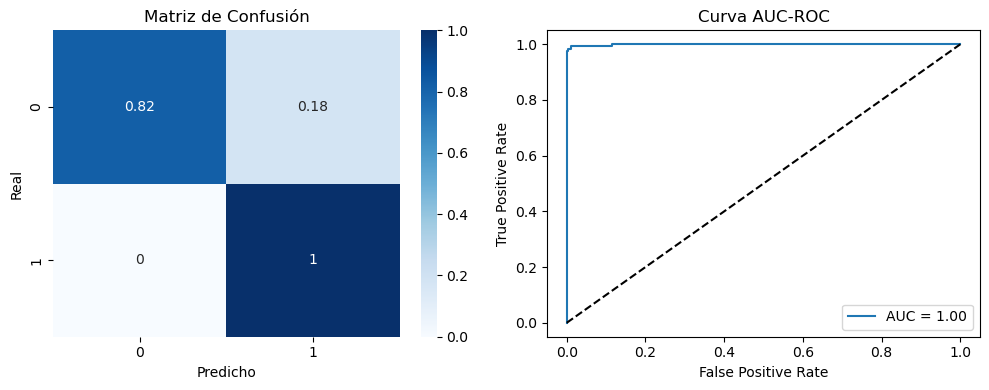

              precision    recall  f1-score   support

           0       1.00      0.82      0.90       285
           1       0.77      1.00      0.87       170

    accuracy                           0.89       455
   macro avg       0.88      0.91      0.88       455
weighted avg       0.91      0.89      0.89       455



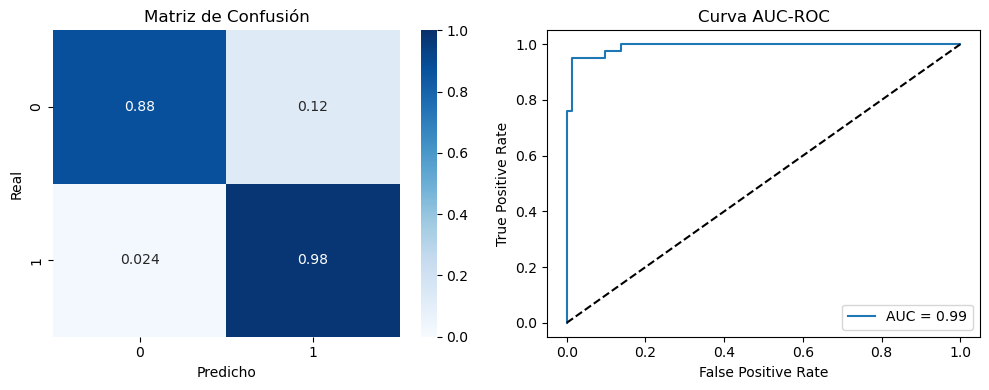

              precision    recall  f1-score   support

           0       0.98      0.88      0.93        72
           1       0.82      0.98      0.89        42

    accuracy                           0.91       114
   macro avg       0.90      0.93      0.91       114
weighted avg       0.92      0.91      0.91       114



In [293]:
# Ejemplo de uso
custom_logit_classifier = LogisticRegressionWithThreshold(threshold=0.01, **log_params)
custom_logit_classifier.fit(X_train_scale_1, y_train)

y_train_pred = custom_logit_classifier.predict(X = X_train_scale_1)
y_test_pred = custom_logit_classifier.predict(X = X_test_scale_1)
y_train_proba = custom_logit_classifier.predict_proba(X_train_scale_1)[:, 1]
y_test_proba = custom_logit_classifier.predict_proba(X_test_scale_1)[:, 1]

resultados(y_train, y_train_pred, y_train_proba)
resultados(y_test, y_test_pred, y_test_proba)

#### Nótese que se debió bajar el umbrar a 1% para detecar todos los casos de cancer pero los falsos positivos no superan el 20%. Podríamos tomar a este como el modelo final pero sería conveniente no tomar una decisión sin antes aumentar el tamaño de la muestra.

In [324]:
car_select_logit_classifier = LogisticRegression(**log_params)
car_select_logit_classifier.fit(X_train_scale_1, y_train)

LogisticRegression(C=4.767461011746043, max_iter=500, penalty='l1',
                   random_state=42, solver='liblinear')

In [326]:
# Obtener los coeficientes y los nombres de las características
coef = car_select_logit_classifier.coef_[0]
features = X_train_scale_1.columns  # Asegúrate de que `X_train_scale_1` contenga el conjunto de datos con nombres de las características

# Crear un DataFrame con los coeficientes y el exponente de los coeficientes
coef_df = pd.DataFrame({
    'Feature': features, 
    'Coefficient': coef,
    'Odds Ratio (exp(Coefficient))': np.exp(coef)  # Calcula el exponente del coeficiente
})

# Ordenar por el valor absoluto de los coeficientes
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Mostrar el DataFrame resultante
coef_df

Feature  Coefficient  Odds Ratio (exp(Coefficient))
7       mean concave points     8.822267                    6783.625110
17     concave points error     5.220547                     185.035346
15        compactness error    -2.825614                       0.059272
28           worst symmetry     1.979751                       7.240942
26          worst concavity     1.970480                       7.174119
21            worst texture     1.526091                       4.600160
11            texture error    -1.494847                       0.224283
18           symmetry error    -1.239213                       0.289612
8             mean symmetry    -0.832343                       0.435029
19  fractal dimension error    -0.637209                       0.528766
16          concavity error    -0.520534                       0.594203
14         smoothness error     0.398394                       1.489431
0               mean radius    -0.370451                       0.690423
4           mean smoothness     0.349488                       1.418341
20             worst radius    -0.220587                       0.802048
12          perimeter error     0.201199                       1.222868
13               area error     0.115649                       1.122602
9    mean fractal dimension    -0.026613                       0.973738
2            mean perimeter    -0.022137                       0.978106
23               worst area     0.012331                       1.012407
3                 mean area     0.006129                       1.006148
22          worst perimeter    -0.004359                       0.995651
6            mean concavity     0.000000                       1.000000
5          mean compactness     0.000000                       1.000000
10             radius error     0.000000                       1.000000
1              mean texture     0.000000                       1.000000
24         worst smoothness     0.000000                       1.000000
25        worst compactness     0.000000                       1.000000
27     worst concave points     0.000000                       1.000000
29  worst fractal dimension     0.000000                       1.000000

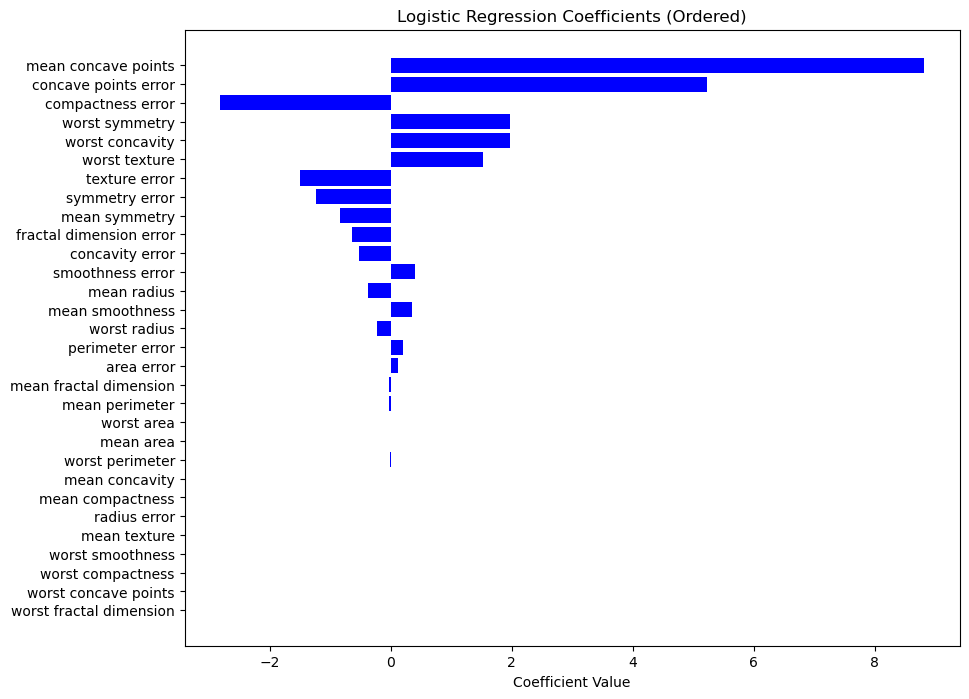

In [308]:
# Graficar los coeficientes
plt.figure(figsize=(10, 8))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='b')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients (Ordered)')
plt.gca().invert_yaxis()  # Para que los valores más grandes estén arriba
plt.show()

- **Coeficientes positivos**: Indican que a medida que el valor de la característica aumenta, la probabilidad de que la observación pertenezca a la clase positiva (por ejemplo, "maligno") aumenta.
- **Coeficientes negativos**: Indican que a medida que el valor de la característica aumenta, la probabilidad de que la observación pertenezca a la clase negativa (por ejemplo, "benigno") aumenta.

Cuanto mayor en valor absoluto sea un coeficiente mayor el impacto en la predicción. Un valor más pequeño (cercano a 0) indica que esa característica tiene menos influencia en la predicción.

#### Interpretacion de Ratio Odds:
Supongamos dos observaciones A y B con todos los valores identicos expecpto uno, el ratio de odds nos permite determinar la relación entre las chances de pertenecer al grupo de interes de una observacion respecto a la otra. Si el ratio es mayor a uno las chances aumentan, si es menor a uno las chances disminuyen, si es igual a uno las chances no se modifican.

#### Estandarizacion y su relacion con los coeficientes
Los coeficientes obtenidos en un modelo con variables estandarizadas indican cómo cambia el logaritmo de los odds cuando una de las variables aumenta en las unidades escaladas. Para llevar los coefientes a las unidades originales hace falta aplicar la transformación inversa correspondiente al metodo con el cual se estandarizo. 


Estandarización con Min-Max Scaling (x-min)/(max-min):
Al estandarizar una característica X con el método min-max, los valores de X se escalan al rango [0,1]. El coeficiente resultante en la regresión logística representa el cambio en el odds ratio por un cambio de 1 en esta escala. Esto significa que un cambio completo desde el valor mínimo de X hasta el valor máximo (que sería un cambio de 1 en la escala min-max) afecta el odds ratio en función de ese coeficiente.
Entonces, para convertir los coeficientes de vuelta a las unidades originales se debe calcular 𝛽orig= 𝛽min-max * (max - min)

Unidades estandarizadas (x-media)/desvio std:
Cuando la variable X se estandariza, el coeficiente se interpreta como el cambio en el odds ratio por un incremento de una desviación estándar en X.
Entonces, sea el coeficiente resultante es 𝛽est, el coeficiente en las unidades originales de X 𝛽orig se puede obtener multiplicando el coeficiente estandarizado por la desviación estándar de la variable X. 𝛽orig= 𝛽est * σ 

In [328]:
# Obtener los coeficientes del modelo entrenado
coef = car_select_logit_classifier.coef_[0]  # Coeficientes de la regresión logística
features = X_train_scale_1.columns  # Nombres de las características (asegúrate de que `X_train_scale_1` tiene los nombres de las características)

# Recuperar el rango de cada variable en los datos originales (X_train)
ranges = X_train.max() - X_train.min()  # Rango de cada variable en la escala original

# Recuperar los coeficientes en las unidades originales
coef_original = coef * ranges

# Crear un DataFrame con los coeficientes en la escala original y los odds ratio
coef_df = pd.DataFrame({
    'Feature': features, 
    'Coefficient (Original Units)': coef_original,  # Coeficientes en las unidades originales
    'Odds Ratio (exp(Coefficient))': np.exp(coef_original)  # Calcula el odds ratio (exponente del coeficiente)
})

# Ordenar por el valor absoluto de los coeficientes (en unidades originales)
coef_df = coef_df.reindex(coef_df['Coefficient (Original Units)'].abs().sort_values(ascending=False).index)

# Mostrar el DataFrame resultante
coef_df

Feature  \
area error                            area error   
worst texture                      worst texture   
worst area                            worst area   
mean area                              mean area   
mean radius                          mean radius   
texture error                      texture error   
worst radius                        worst radius   
perimeter error                  perimeter error   
mean perimeter                    mean perimeter   
worst concavity                  worst concavity   
mean concave points          mean concave points   
worst symmetry                    worst symmetry   
worst perimeter                  worst perimeter   
compactness error              compactness error   
concave points error        concave points error   
concavity error                  concavity error   
mean symmetry                      mean symmetry   
symmetry error                    symmetry error   
mean smoothness                  mean smoothness   
fractal dimension error  fractal dimension error   
smoothness error                smoothness error   
mean fractal dimension    mean fractal dimension   
mean texture                        mean texture   
radius error                        radius error   
mean concavity                    mean concavity   
worst smoothness                worst smoothness   
worst compactness              worst compactness   
mean compactness                mean compactness   
worst concave points        worst concave points   
worst fractal dimension  worst fractal dimension   

                         Coefficient (Original Units)  \
area error                                  61.918421   
worst texture                               57.258934   
worst area                                  50.172124   
mean area                                   14.450162   
mean radius                                 -7.827269   
texture error                               -6.763882   
worst radius                                -6.200696   
perimeter error                              4.270042   
mean perimeter                              -3.203442   
worst concavity                              2.467041   
mean concave points                          1.775040   
worst symmetry                               1.004328   
worst perimeter                             -0.875151   
compactness error                           -0.294282   
concave points error                         0.275593   
concavity error                             -0.206131   
mean symmetry                               -0.164804   
symmetry error                              -0.088068   
mean smoothness                              0.035260   
fractal dimension error                     -0.018444   
smoothness error                             0.011720   
mean fractal dimension                      -0.001256   
mean texture                                 0.000000   
radius error                                 0.000000   
mean concavity                               0.000000   
worst smoothness                             0.000000   
worst compactness                            0.000000   
mean compactness                             0.000000   
worst concave points                         0.000000   
worst fractal dimension                      0.000000   

                         Odds Ratio (exp(Coefficient))  
area error                                7.777299e+26  
worst texture                             7.366122e+24  
worst area                                6.158522e+21  
mean area                                 1.886364e+06  
mean radius                               3.987129e-04  
texture error                             1.154738e-03  
worst radius                              2.028019e-03  
perimeter error                           7.152462e+01  
mean perimeter                            4.062215e-02  
worst concavity                           1.178751e+01  
mean concave points              

In [330]:
car_select_logit_classifier = LogisticRegression(**log_params)
car_select_logit_classifier.fit(X_train, y_train)

# Obtener los coeficientes y los nombres de las características
coef = car_select_logit_classifier.coef_[0]
features = X_train_scale_1.columns  # Asegúrate de que `X_train_scale_1` contenga el conjunto de datos con nombres de las características

# Crear un DataFrame con los coeficientes y el exponente de los coeficientes
coef_df = pd.DataFrame({
    'Feature': features, 
    'Coefficient': coef,
    'Odds Ratio (exp(Coefficient))': np.exp(coef)  # Calcula el exponente del coeficiente
})

# Ordenar por el valor absoluto de los coeficientes
coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Mostrar el DataFrame resultante
coef_df

Feature  Coefficient  Odds Ratio (exp(Coefficient))
27     worst concave points    14.262097                   1.562968e+06
28           worst symmetry     5.097332                   1.635848e+02
11            texture error    -4.209710                   1.485067e-02
0               mean radius    -3.296449                   3.701436e-02
26          worst concavity     2.355946                   1.054811e+01
20             worst radius    -1.002269                   3.670456e-01
21            worst texture     0.751301                   2.119756e+00
12          perimeter error     0.565853                   1.760949e+00
1              mean texture    -0.362806                   6.957213e-01
2            mean perimeter     0.248286                   1.281826e+00
13               area error     0.133470                   1.142787e+00
22          worst perimeter    -0.043832                   9.571150e-01
23               worst area     0.021092                   1.021316e+00
3                 mean area     0.015042                   1.015155e+00
18           symmetry error     0.000000                   1.000000e+00
24         worst smoothness     0.000000                   1.000000e+00
25        worst compactness     0.000000                   1.000000e+00
19  fractal dimension error     0.000000                   1.000000e+00
15        compactness error     0.000000                   1.000000e+00
17     concave points error     0.000000                   1.000000e+00
16          concavity error     0.000000                   1.000000e+00
14         smoothness error     0.000000                   1.000000e+00
10             radius error     0.000000                   1.000000e+00
9    mean fractal dimension     0.000000                   1.000000e+00
8             mean symmetry     0.000000                   1.000000e+00
7       mean concave points     0.000000                   1.000000e+00
6            mean concavity     0.000000                   1.000000e+00
5          mean compactness     0.000000                   1.000000e+00
4           mean smoothness     0.000000                   1.000000e+00
29  worst fractal dimension     0.000000                   1.000000e+00

#### Importancia de las caracteristicas **para el modelo**